In [1]:
%pip install kagglehub
%pip install pandas
%pip install -U jupyter ipywidgets
%pip install -U jupyterlab-widgets
%pip install seaborn
%pip install tabulate
%pip install statsmodels --index-url=https://pypi.org/simple
%pip install sklearn
%pip install scikit-learn

from tabulate import tabulate
import kagglehub
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
      More information is available at
      https://github.com/scikit-learn/sklearn-

## INFORMAZIONI SUL DATASET

In [2]:
# Scaricare il dataset da Kaggle (simulato in locale per questo esempio)
path = kagglehub.dataset_download("khushipitroda/stock-market-historical-data-of-top-10-companies")
file_path = os.path.join(path, "data.csv")

# Leggere il file CSV
df = pd.read_csv(file_path)

# Stampare numero di righe nel dataset
print(f"Numero di righe nel dataset: {df.shape[0]}\n")

# Stampare le prime righe in una tabella formattata
print("Prime righe del dataset:\n")
df.head()

Numero di righe nel dataset: 25160

Prime righe del dataset:



,Company,Date,Close/Last,Volume,Open,High,Low
0,AAPL,07/17/2023,$193.99,50520160,$191.90,$194.32,$191.81
1,AAPL,07/14/2023,$190.69,41616240,$190.23,$191.1799,$189.63
2,AAPL,07/13/2023,$190.54,41342340,$190.50,$191.19,$189.78
3,AAPL,07-12-2023,$189.77,60750250,$189.68,$191.70,$188.47
4,AAPL,07-11-2023,$188.08,46638120,$189.16,$189.30,$186.60


## FASE DI ETL

In [3]:
# Rimuovere duplicati
df_cleaned = df.drop_duplicates()

# Rimuovere valori nulli
df_cleaned = df.dropna()

print(f"Numero di righe nel dataset senza valori nulli: {df_cleaned.shape[0]}")
# Rinominare le colonne
df_cleaned = df_cleaned.rename(columns={
    'Date': 'date',
    'Open': 'open',
    'High': 'high',
    'Low': 'low',
    'Close/Last': 'close/last',
    'Volume': 'volume',
    'Company': 'company'
})

# Funzione per convertire i formati delle date
def correct_date_format(date):
    try:
        # Tenta di interpretare la data come MM/DD/YYYY (o MM-DD-YYYY)
        if '-' in date or '/' in date:
            return pd.to_datetime(date, dayfirst=False, errors='coerce').strftime('%d/%m/%Y')
        else:
            return date  # Restituisci la data originale se non è in un formato valido
    except Exception as e:
        print(f"Errore durante la conversione della data: {date}")
        return None  # Restituisci None per valori non validi

# Applicare la funzione alla colonna 'date'
df_cleaned['date'] = df_cleaned['date'].astype(str).apply(correct_date_format)

# Convertire la colonna 'date' in datetime senza specificare il formato
df_cleaned['date'] = pd.to_datetime(df_cleaned['date'], errors='coerce')

# Pulizia e conversione della colonna 'close/last'
df_cleaned['close/last'] = df_cleaned['close/last'].replace('[\$,]', '', regex=True).astype(float)

# Aggiungere colonne derivate
df_cleaned['daily_return'] = df_cleaned['close/last'].pct_change() * 100
df_cleaned['rolling_average_7d'] = df_cleaned['close/last'].rolling(window=7).mean()
df_cleaned['rolling_average_30d'] = df_cleaned['close/last'].rolling(window=30).mean()

print("Ultimi dati:\n")
df_cleaned.tail()

Numero di righe nel dataset senza valori nulli: 25160
Ultimi dati:



,company,date,close/last,volume,open,high,low,daily_return,rolling_average_7d,rolling_average_30d
25155,NFLX,2013-07-24,34.4714,33395351,$35.6743,$36.0357,$34.3143,-2.204910,35.034157,37.436623
25156,NFLX,2013-07-23,35.7514,76792963,$35.9143,$37.4621,$35.1714,3.713223,35.057414,37.235813
25157,NFLX,2013-07-22,37.4228,44791095,$38.1214,$38.3928,$36.7314,4.675062,35.414057,37.107050
25158,NFLX,2013-07-19,37.7966,18098750,$38.2043,$38.2784,$37.5971,0.998856,35.838886,37.014983
25159,NFLX,2013-07-18,38.0586,20418642,$38.6157,$38.6157,$37.7143,0.693184,36.276643,36.912890


## Informazioni sul dataset pulito

In [4]:
# Informazioni generali sul dataset
print("Informazioni generali sul dataset:")
df_info = pd.DataFrame({
    "Column": df_cleaned.columns,
    "Non-Null Count": df_cleaned.notnull().sum().values,
    "Dtype": df_cleaned.dtypes.values
})
print(tabulate(df_info, headers="keys", tablefmt="grid"))

# Statistiche descrittive
print("\nStatistiche descrittive:")
df_stats = df_cleaned.describe().T  
df_stats.head()


Informazioni generali sul dataset:
+----+---------------------+------------------+----------------+
|    | Column              |   Non-Null Count | Dtype          |
+====+=====================+==================+================+
|  0 | company             |            25160 | object         |
+----+---------------------+------------------+----------------+
|  1 | date                |            25160 | datetime64[ns] |
+----+---------------------+------------------+----------------+
|  2 | close/last          |            25160 | float64        |
+----+---------------------+------------------+----------------+
|  3 | volume              |            25160 | int64          |
+----+---------------------+------------------+----------------+
|  4 | open                |            25160 | object         |
+----+---------------------+------------------+----------------+
|  5 | high                |            25160 | object         |
+----+---------------------+------------------+--------

,count,mean,min,25%,50%,75%,max,std
date,25160,2018-07-15 16:11:49.697933056,2013-07-18 00:00:00,2016-01-14 18:00:00,2018-07-16 12:00:00,2021-01-13 06:00:00,2023-07-17 00:00:00,NaN
close/last,25160.0,102.455878,1.62,36.5675,65.68,134.235025,691.69,101.991372
volume,25160.0,51317642.694754,1143952.0,12003942.5,26720830.0,68572694.0,1065209454.0,63991428.709405
daily_return,25159.0,0.562116,-34.33584,-1.145935,-0.074599,0.92828,9599.353448,62.767819
rolling_average_7d,25154.0,102.453101,1.701429,36.6825,65.784443,134.776786,680.15,101.816504


## Analisi descrittiva

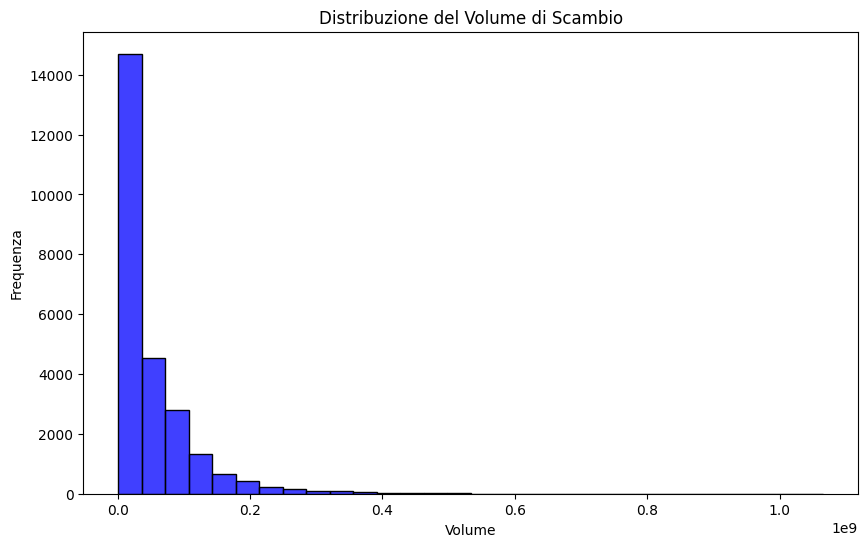

In [5]:
# Istogramma del volume di scambio
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned['volume'], kde=False, bins=30, color='blue')
plt.title('Distribuzione del Volume di Scambio')
plt.xlabel('Volume')
plt.ylabel('Frequenza')
# plt.savefig('volume_histogram.png')
plt.show()

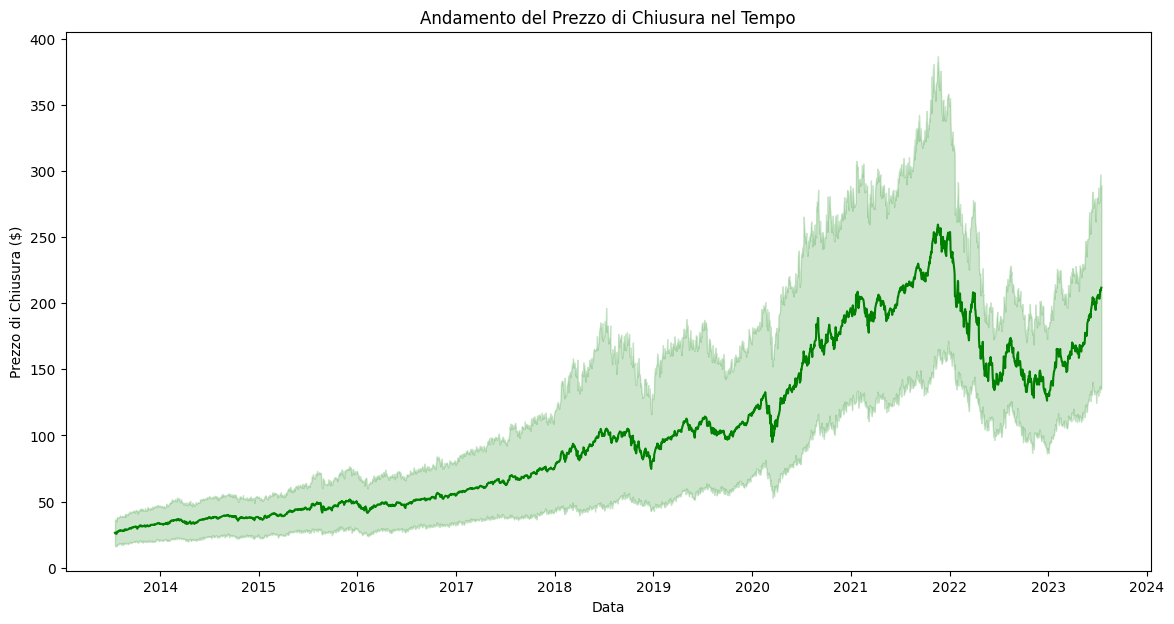

In [6]:
# Grafico a linee per l'andamento del prezzo di chiusura
plt.figure(figsize=(14, 7))
sns.lineplot(x='date', y='close/last', data=df_cleaned, color='green')
plt.title('Andamento del Prezzo di Chiusura nel Tempo')
plt.xlabel('Data')
plt.ylabel('Prezzo di Chiusura ($)')
# plt.savefig('line_plot_close.png')
plt.show()

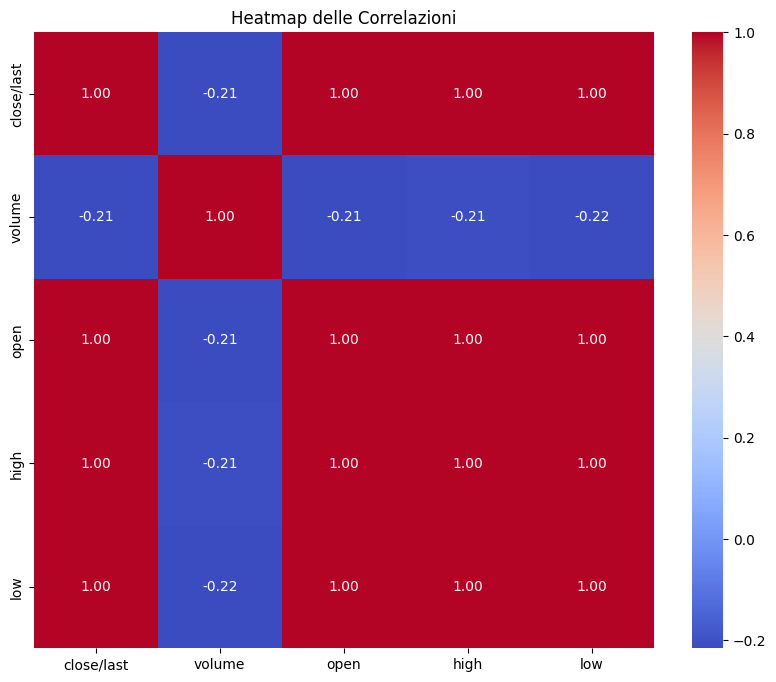

In [7]:
# Conversione delle colonne 'open', 'high', e 'low' in float
columns_to_convert = ['open', 'high', 'low']

for col in columns_to_convert:
    df_cleaned[col] = df_cleaned[col].replace('[\$,]', '', regex=True).astype(float)

# Heatmap delle correlazioni
plt.figure(figsize=(10, 8))
corr = df_cleaned[['close/last', 'volume', 'open', 'high', 'low']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap delle Correlazioni')
# plt.savefig('heatmap_corr.png')
plt.show()

## INIZIO SERIE TEMPORALI

In [8]:
# Utilizzare il dataset pulito
df_apple = df_cleaned[df_cleaned['company'] == 'AAPL'][['date', 'close/last', 'volume']]

# Assicurarsi che la colonna 'date' sia trattata come stringa per applicare replace
df_apple['date'] = df_apple['date'].astype(str).str.replace('-', '/')

# Convertire la colonna 'date' in formato datetime
df_apple['date'] = pd.to_datetime(df_apple['date'], errors='coerce')

# Verifica righe con valori NaT
print(f"Valori NaT nella colonna 'date': {df_apple['date'].isnull().sum()}")
if df_apple['date'].isnull().any():
    print("Righe con date non valide:")
    print(df_apple[df_apple['date'].isnull()])

# Rimuovere righe con date mancanti o valori mancanti in 'close/last' o 'volume'
df_apple = df_apple.dropna(subset=['date', 'close/last', 'volume'])

# Conferma i valori minimi e massimi di 'date'
print(f"Data minima: {df_apple['date'].min()}")
print(f"Data massima: {df_apple['date'].max()}")

# Crea una sequenza completa di date tra il minimo e il massimo
full_date_range = pd.date_range(start=df_apple['date'].min(), end=df_apple['date'].max(), freq='D')

# Reindicizza il DataFrame con questa sequenza
df_apple = df_apple.set_index('date').reindex(full_date_range)

# Rinomina l'indice in 'date'
df_apple.index.name = 'date'

# Interpola i valori mancanti
df_apple['close/last'] = df_apple['close/last'].interpolate(method='linear')
df_apple['volume'] = df_apple['volume'].interpolate(method='linear')

# Verifica la frequenza dei dati
freq = df_apple.index.inferred_freq
print(f"Frequenza rilevata: {freq}")

# Controllo finale
print(f"Numero di osservazioni nella serie temporale: {len(df_apple)}")
print("Prime righe della serie temporale:")
print(df_apple.head())
print("Ultime righe della serie temporale:")
print(df_apple.tail())


Valori NaT nella colonna 'date': 0
Data minima: 2013-07-18 00:00:00
Data massima: 2023-07-17 00:00:00
Frequenza rilevata: D
Numero di osservazioni nella serie temporale: 3652
Prime righe della serie temporale:
            close/last        volume
date                                
2013-07-18     15.4199  2.186325e+08
2013-07-19     15.1768  2.685489e+08
2013-07-20     15.1930  2.482489e+08
2013-07-21     15.2092  2.279490e+08
2013-07-22     15.2254  2.076490e+08
Ultime righe della serie temporale:
            close/last        volume
date                                
2023-07-13      190.54  4.134234e+07
2023-07-14      190.69  4.161624e+07
2023-07-15      191.79  4.458421e+07
2023-07-16      192.89  4.755219e+07
2023-07-17      193.99  5.052016e+07


## DECOMPOSIZIONE SERIE TEMPORALE

Frequenza rilevata: D


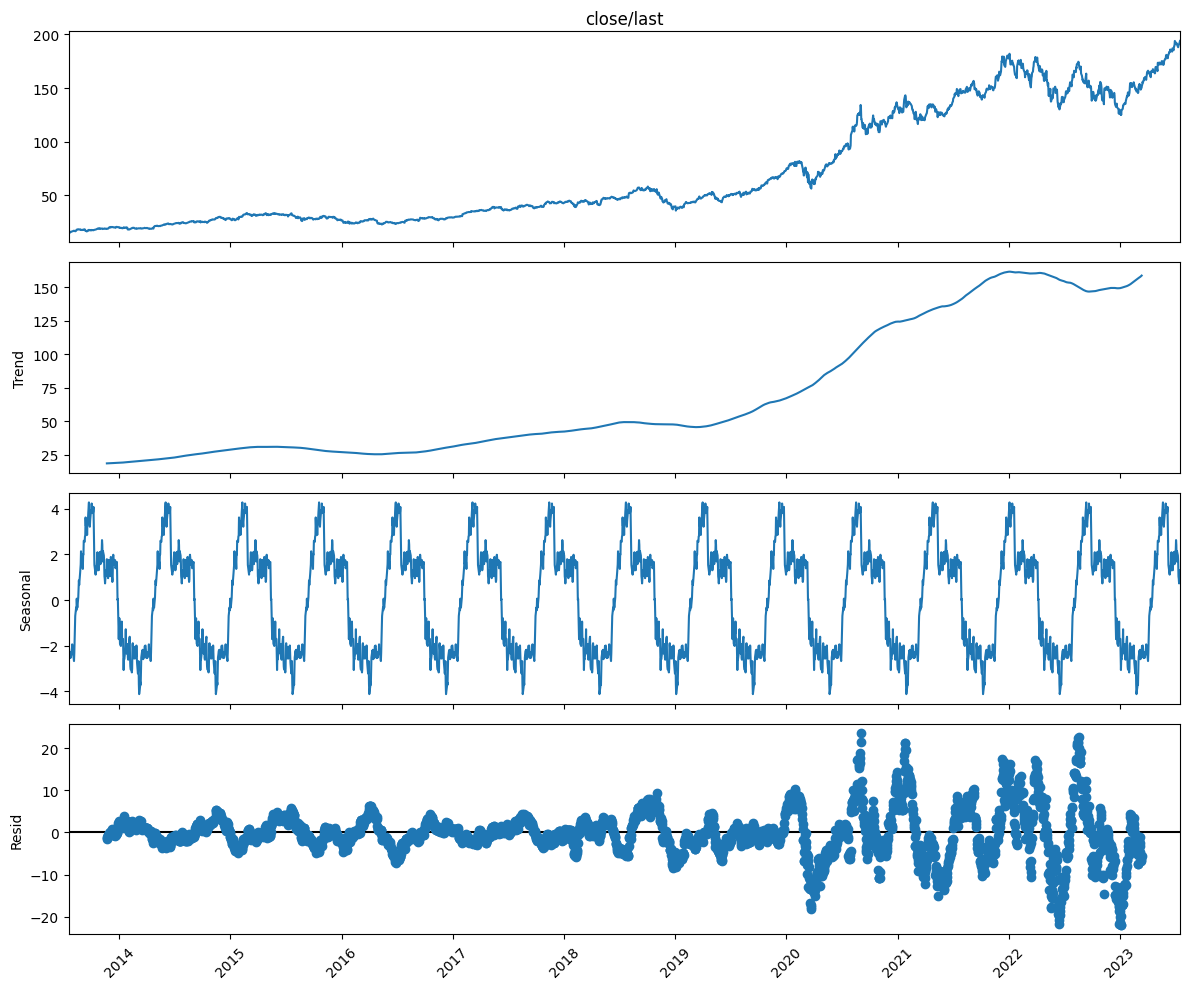

In [9]:
# Assicurati che l'indice sia di tipo datetime e ordinato
if not isinstance(df_apple.index, pd.DatetimeIndex):
    df_apple.index = pd.to_datetime(df_apple.index)

df_apple = df_apple.sort_index()

# Verifica che non ci siano valori mancanti nella colonna 'close/last'
if df_apple['close/last'].isnull().any():
    print("Ci sono valori mancanti nella colonna 'close/last'. Verranno rimossi.")
    df_apple = df_apple.dropna(subset=['close/last'])

# Determina automaticamente la frequenza dei dati
freq = df_apple.index.inferred_freq
print(f"Frequenza rilevata: {freq}")

# Imposta il periodo in base alla frequenza
if freq == 'D':  # Dati giornalieri
    period = 252  # Stagionalità annuale (252 giorni di trading)
elif freq == 'W':  # Dati settimanali
    period = 52  # Stagionalità annuale (52 settimane)
elif freq == 'M':  # Dati mensili
    period = 12  # Stagionalità annuale (12 mesi)
else:
    print("Frequenza non riconosciuta. Utilizzo il periodo predefinito per dati giornalieri.")
    period = 252

# Decomposizione additiva
try:
    decomposition = seasonal_decompose(df_apple['close/last'], model='additive', period=period)

    # Plot della decomposizione
    fig = decomposition.plot()

    # Imposta la dimensione del grafico
    fig.set_size_inches(12, 10)

    # Intervallo personalizzato per i tick dell'asse x
    xticks_interval = 252  # Intervallo di un anno per dati giornalieri
    xticks = pd.date_range(start=df_apple.index.min(), end=df_apple.index.max(), freq='YS')
    
    for ax in fig.axes:
        ax.set_xticks(xticks)
        ax.set_xticklabels([tick.strftime('%Y') for tick in xticks], rotation=45)

    # Ottimizza lo spazio tra i sottografi
    plt.tight_layout()
    plt.show()

except ValueError as e:
    print(f"Errore durante la decomposizione: {e}")
    print("Verifica che la serie temporale abbia una lunghezza sufficiente rispetto al periodo.")

## Verifica stazionarietà serie temporale

In [10]:
# Test Dickey-Fuller
result = adfuller(df_apple['close/last'])

# Stampa i risultati
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
print(f"Critical Values: {result[4]}")

ADF Statistic: 0.6861245831836631
p-value: 0.9895568550388313
Critical Values: {'1%': np.float64(-3.4321522387754775), '5%': np.float64(-2.862336328589075), '10%': np.float64(-2.567193897993964)}


❌ Non stazionaria, per questo la andremo a differenziare ⬇️

## Differenziazione serie temporale

Test di stazionarietà sulla serie differenziata:
ADF Statistic: -12.754663960431252
p-value: 8.3896223550836e-24
Critical Values:
   1%: -3.4321522387754775
   5%: -2.862336328589075
   10%: -2.567193897993964


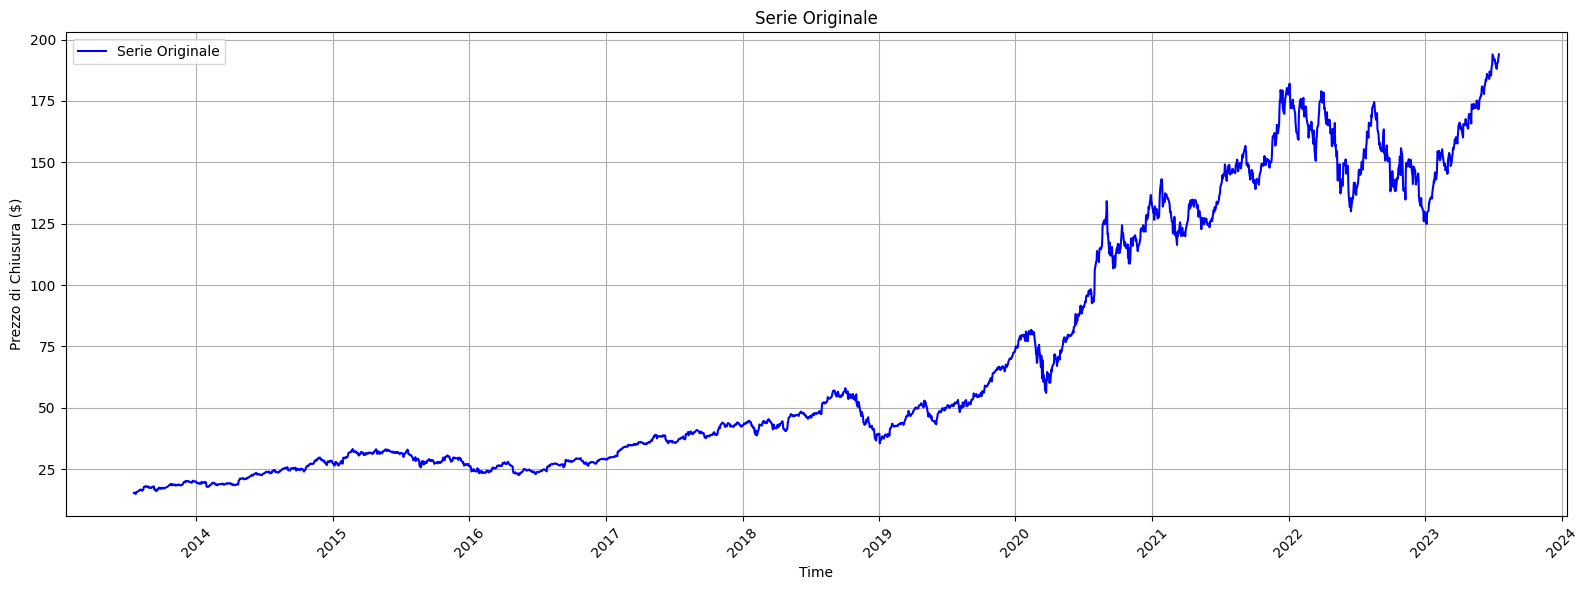

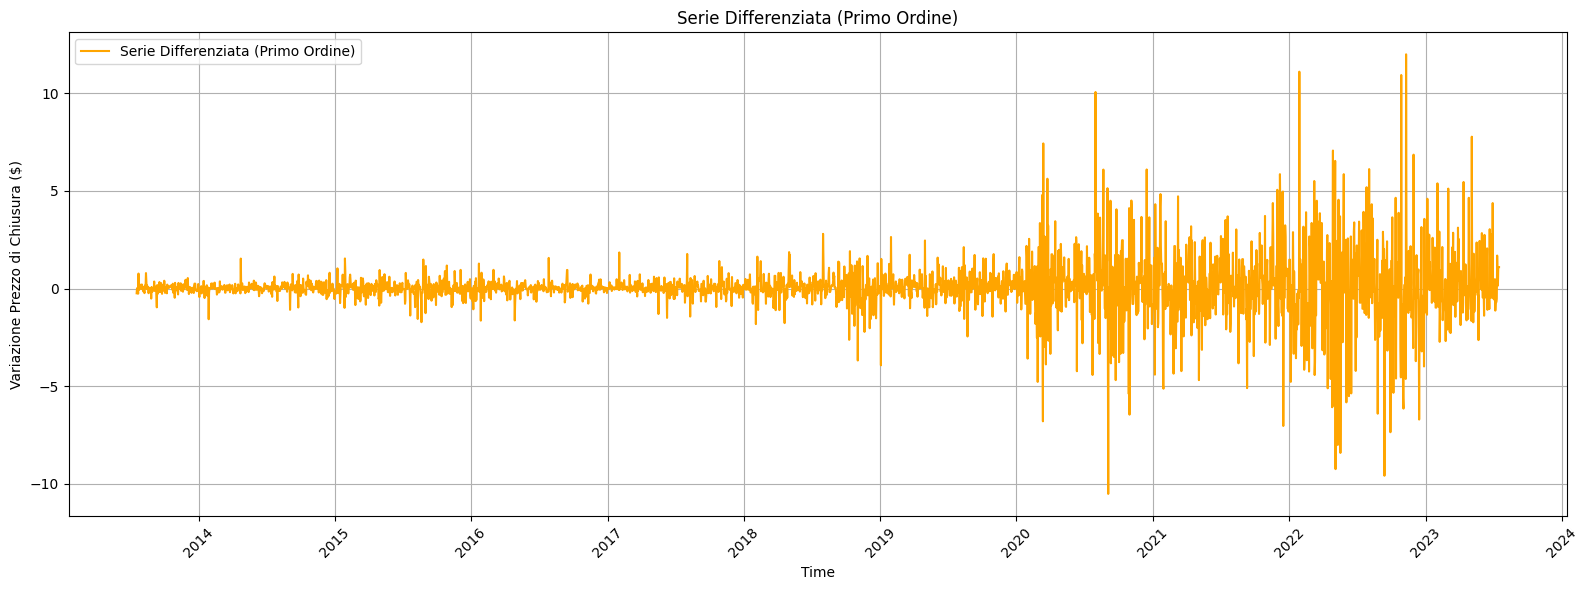

In [11]:
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

# Differenziazione di primo ordine
differenced_data = df_apple['close/last'].diff().dropna()

# Verifica della stazionarietà della serie differenziata
result_diff = adfuller(differenced_data)  # Applica il test di Dickey-Fuller alla serie differenziata
print("Test di stazionarietà sulla serie differenziata:")
print(f"ADF Statistic: {result_diff[0]}")
print(f"p-value: {result_diff[1]}")
print("Critical Values:")
for key, value in result_diff[4].items():
    print(f"   {key}: {value}")

# Grafico della serie originale
plt.figure(figsize=(16, 6))
plt.plot(df_apple['close/last'], label='Serie Originale', color='blue')
plt.title('Serie Originale')
plt.xlabel('Time')
plt.ylabel('Prezzo di Chiusura ($)')
plt.grid()
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Grafico della serie differenziata
plt.figure(figsize=(16, 6))
plt.plot(differenced_data, label='Serie Differenziata (Primo Ordine)', color='orange')
plt.title('Serie Differenziata (Primo Ordine)')
plt.xlabel('Time')
plt.ylabel('Variazione Prezzo di Chiusura ($)')
plt.grid()
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**Stima manuale ACF e PACF**

Test ADF sulla serie originale:
ADF Statistic: 0.6861245831836631
p-value: 0.9895568550388313
Critical Values: {'1%': np.float64(-3.4321522387754775), '5%': np.float64(-2.862336328589075), '10%': np.float64(-2.567193897993964)}
La serie non è stazionaria. Si procede con la differenziazione.

Test ADF sulla serie differenziata:
ADF Statistic: -12.754663960431252
p-value: 8.3896223550836e-24
Critical Values: {'1%': np.float64(-3.4321522387754775), '5%': np.float64(-2.862336328589075), '10%': np.float64(-2.567193897993964)}
La serie differenziata è stazionaria.


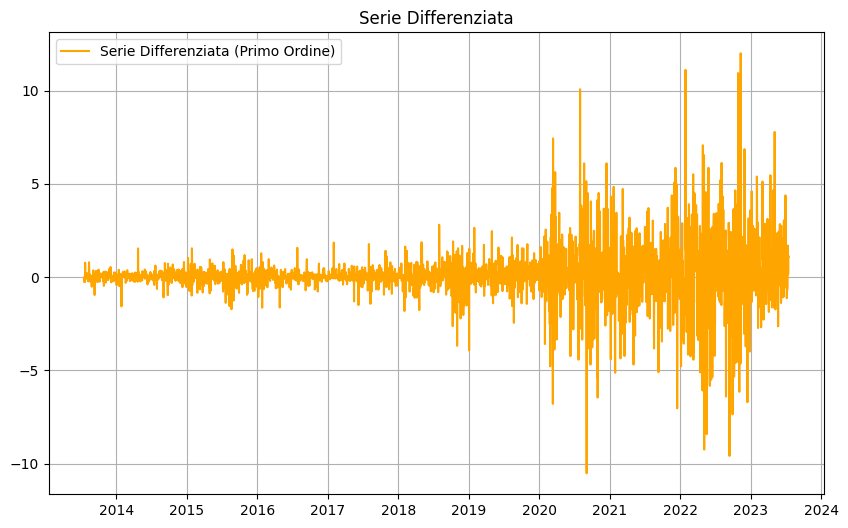

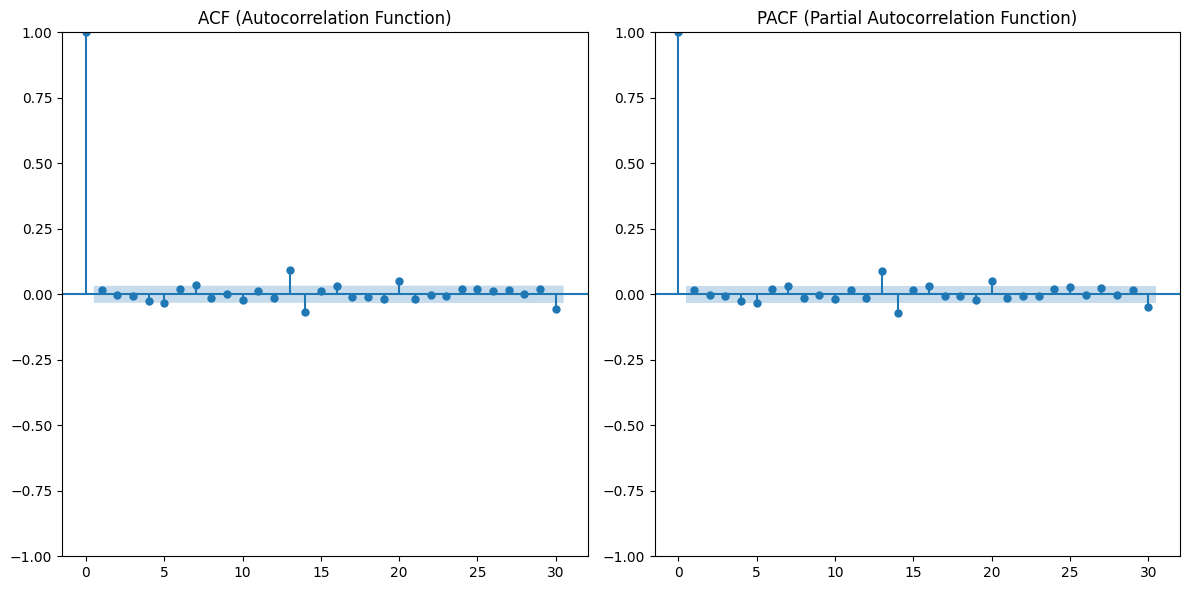

In [12]:
import pandas as pd
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# Differenziazione e test di stazionarietà
def analyze_stationarity(data, column, max_lags=30):
    # Verifica stazionarietà sulla serie originale
    result = adfuller(data[column])
    print(f"Test ADF sulla serie originale:")
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print(f"Critical Values: {result[4]}")
    if result[1] > 0.05:
        print("La serie non è stazionaria. Si procede con la differenziazione.")

    # Differenziazione di primo ordine
    differenced_data = data[column].diff().dropna()

    # Verifica stazionarietà sulla serie differenziata
    result_diff = adfuller(differenced_data)
    print("\nTest ADF sulla serie differenziata:")
    print(f"ADF Statistic: {result_diff[0]}")
    print(f"p-value: {result_diff[1]}")
    print(f"Critical Values: {result_diff[4]}")
    if result_diff[1] <= 0.05:
        print("La serie differenziata è stazionaria.")

    # Plot della serie differenziata
    plt.figure(figsize=(10, 6))
    plt.plot(differenced_data, label="Serie Differenziata (Primo Ordine)", color='orange')
    plt.title("Serie Differenziata")
    plt.legend()
    plt.grid()
    plt.show()

    # Grafici ACF e PACF
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plot_acf(differenced_data, lags=max_lags, ax=plt.gca())
    plt.title("ACF (Autocorrelation Function)")
    plt.subplot(122)
    plot_pacf(differenced_data, lags=max_lags, ax=plt.gca())
    plt.title("PACF (Partial Autocorrelation Function)")
    plt.tight_layout()
    plt.show()

    return differenced_data

differenced_data = analyze_stationarity(df_apple, 'close/last', max_lags=30)

d=1 (necessaria per rendere la serie stazionaria).

p=1 (dal PACF).

q=1 (dall'ACF).

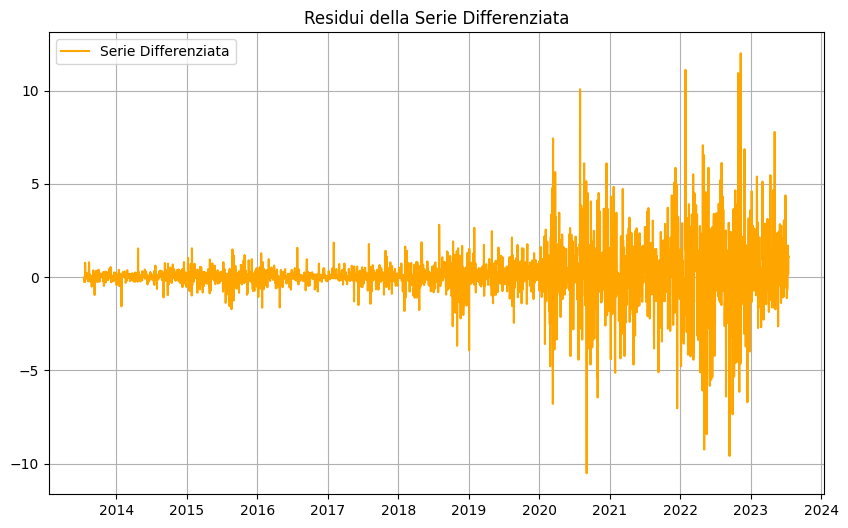

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(differenced_data, label="Serie Differenziata", color='orange')
plt.title("Residui della Serie Differenziata")
plt.legend()
plt.grid()
plt.show()


In [14]:
result_resid = adfuller(differenced_data)
print(f"ADF Statistic: {result_resid[0]}")
print(f"p-value: {result_resid[1]}")


ADF Statistic: -12.754663960431252
p-value: 8.3896223550836e-24


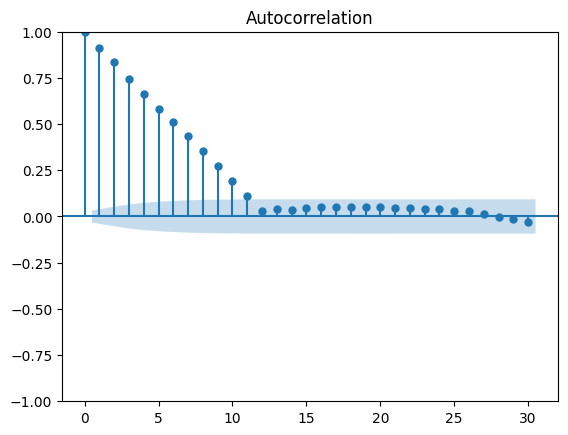

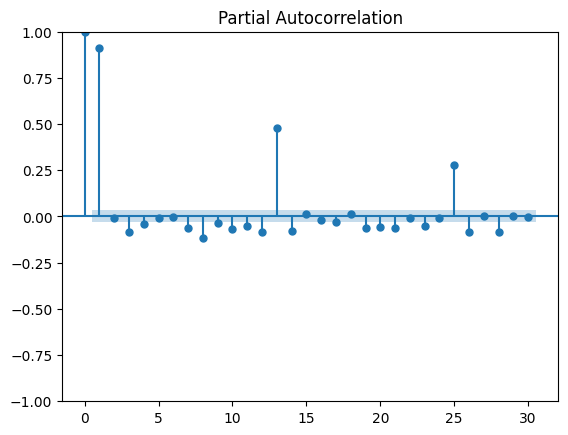

In [15]:
seasonal_diff = df_apple['close/last'].diff(12).dropna()
plot_acf(seasonal_diff, lags=30)
plot_pacf(seasonal_diff, lags=30)
plt.show()


## ARRIVATI FINO A QUI SI PUO' DIRE CHE d=1 PER FORZA:

Ci siamo fermati a d=1 perché:

- La serie differenziata di primo ordine risultava stazionaria (test ADF con p-value < 0.05).
- I grafici ACF/PACF e la struttura della serie suggerivano che la stazionarietà era stata raggiunta.
- Differenziare ulteriormente (d=2) avrebbe comportato il rischio di sovradifferenziazione.

**Ora stimiamo p e q in modo automatico**

In [16]:
import itertools
import statsmodels.api as sm
import pandas as pd

# Dividere il dataset in training e test
split_date = '2019-12-31'
train_data = df_apple[:split_date][['close/last', 'volume']]
test_data = df_apple[split_date:][['close/last', 'volume']]

# Parametri per il modello ARIMA
p = range(0, 3)  # Valori possibili di p (ordine autoregressivo)
d = [1]          # Differenziazione basata sull'analisi
q = range(0, 3)  # Valori possibili di q (ordine media mobile)

# Genera tutte le combinazioni di (p, d, q)
pdq = list(itertools.product(p, d, q))

# Variabili per tracciare il miglior modello
best_aic = float('inf')
best_order = None
best_model = None

# Itera su tutte le combinazioni di parametri
for param in pdq:
    try:
        # Adatta il modello ARIMA
        model = sm.tsa.ARIMA(train_data['close/last'], order=param)
        results = model.fit()
        
        # Confronta l'AIC per trovare il modello migliore
        if results.aic < best_aic:
            best_aic = results.aic
            best_order = param
            best_model = results
    except Exception as e:
        # Ignora gli errori e continua
        print(f"Errore con i parametri {param}: {e}")
        continue

# Stampa il miglior modello trovato
if best_order:
    print(f"Miglior modello ARIMA: ordine={best_order}, AIC={best_aic}")
else:
    print("Nessun modello ARIMA valido trovato.")

# Dettagli del miglior modello
if best_model:
    print(best_model.summary())


Miglior modello ARIMA: ordine=(2, 1, 1), AIC=2718.3895314925403
                               SARIMAX Results                                
Dep. Variable:             close/last   No. Observations:                 2358
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -1355.195
Date:                Thu, 28 Nov 2024   AIC                           2718.390
Time:                        20:16:28   BIC                           2741.450
Sample:                    07-18-2013   HQIC                          2726.787
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9118      0.016    -57.173      0.000      -0.943      -0.881
ar.L2          0.0627      0.013      4.796      0.000       0.037 

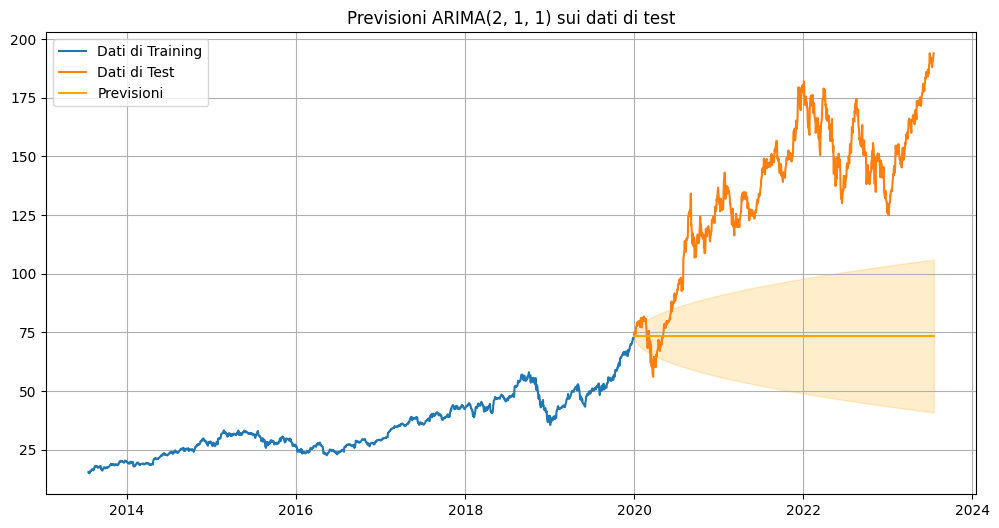

In [17]:
# Previsioni sui dati di test
forecast = best_model.get_forecast(steps=len(test_data))
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Grafico delle previsioni
plt.figure(figsize=(12, 6))
plt.plot(train_data['close/last'], label='Dati di Training')
plt.plot(test_data['close/last'], label='Dati di Test')
plt.plot(forecast_mean, label='Previsioni', color='orange')
plt.fill_between(forecast_conf_int.index, 
                 forecast_conf_int.iloc[:, 0], 
                 forecast_conf_int.iloc[:, 1], 
                 color='orange', alpha=0.2)
plt.title("Previsioni ARIMA(2, 1, 1) sui dati di test")
plt.legend()
plt.grid()
plt.show()


In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calcolo delle metriche
mse = mean_squared_error(test_data['close/last'], forecast_mean)
mae = mean_absolute_error(test_data['close/last'], forecast_mean)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


Mean Absolute Error (MAE): 62.44457658364986
Mean Squared Error (MSE): 4798.063162437302
Root Mean Squared Error (RMSE): 69.2680529713179


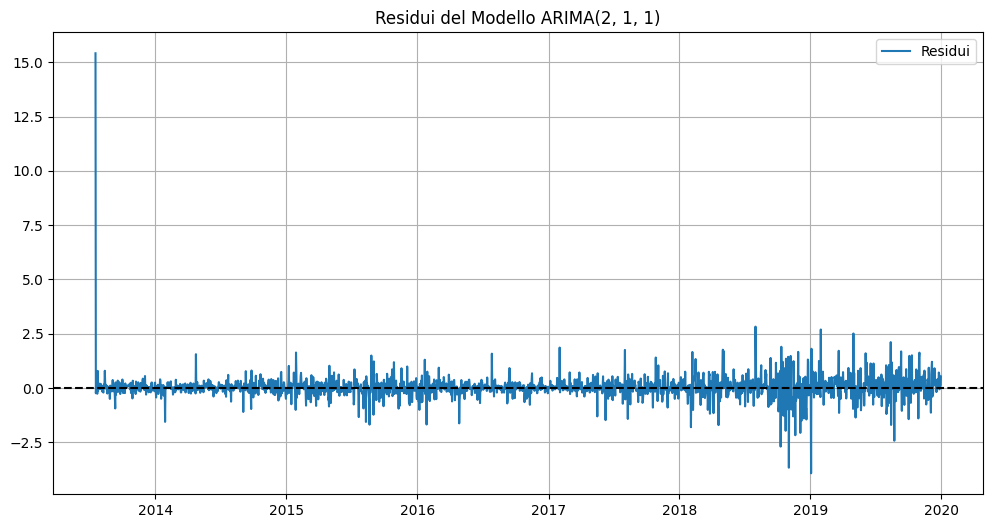

ADF Statistic: -60.80431050039572
p-value: 0.0


In [19]:
residuals = best_model.resid

# Plot dei residui
plt.figure(figsize=(12, 6))
plt.plot(residuals, label="Residui")
plt.axhline(y=0, color='black', linestyle='--')
plt.title("Residui del Modello ARIMA(2, 1, 1)")
plt.legend()
plt.grid()
plt.show()

# Test di Dickey-Fuller sui residui
adf_test = adfuller(residuals)
print(f"ADF Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")


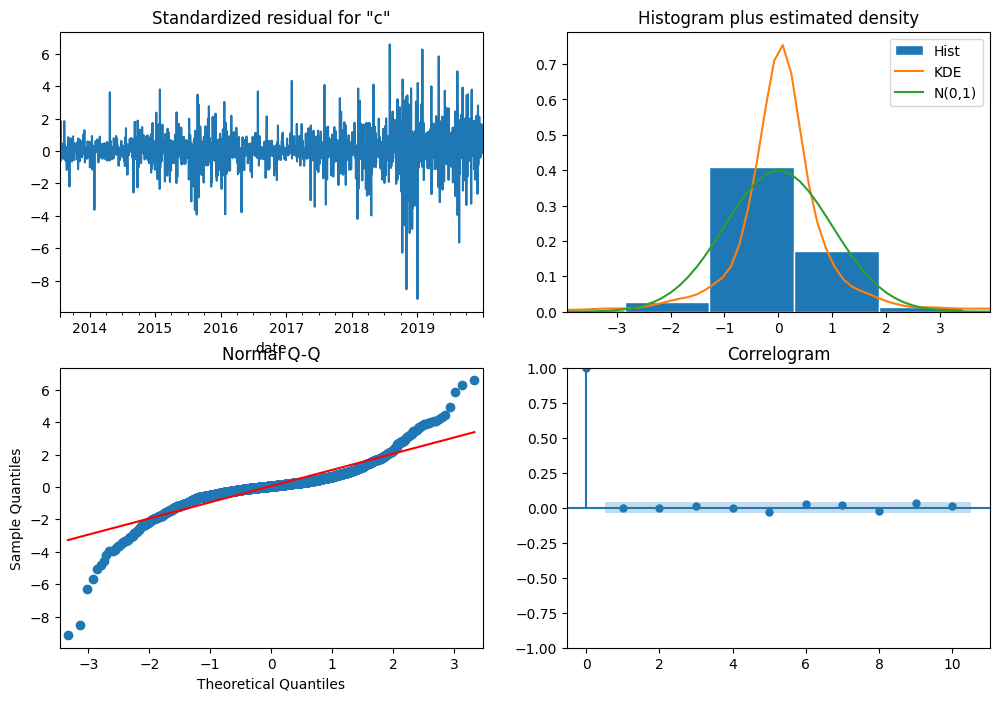

Test di Ljung-Box:
     lb_stat  lb_pvalue
10  7.560396    0.67169


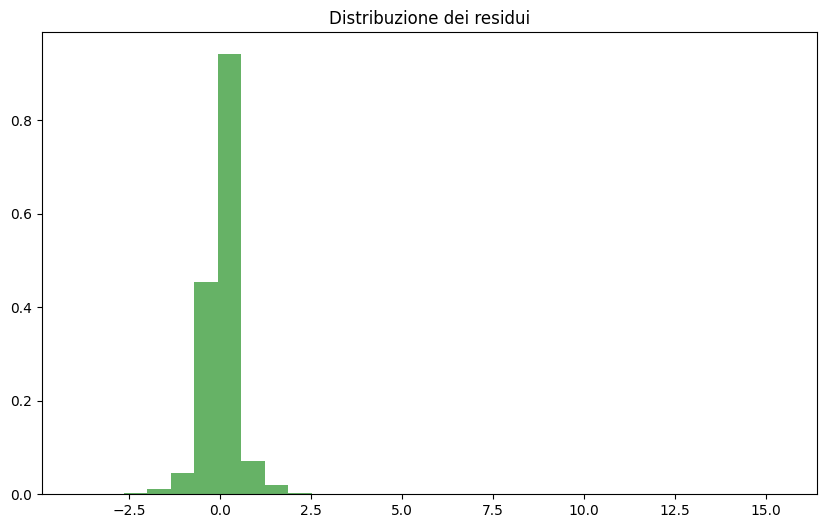

In [20]:
# Grafici diagnostici
best_model.plot_diagnostics(figsize=(12, 8))
plt.show()

# Analisi dei residui
residuals = best_model.resid

# Test di Ljung-Box per l'autocorrelazione nei residui
from statsmodels.stats.diagnostic import acorr_ljungbox
ljung_box_results = acorr_ljungbox(residuals, lags=[10], return_df=True)
print("Test di Ljung-Box:")
print(ljung_box_results)

# Grafico della distribuzione dei residui
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, density=True, alpha=0.6, color='g')
plt.title("Distribuzione dei residui")
plt.show()


Problemi Identificati

Previsioni Piatte:
ARIMA(2, 1, 1) non cattura adeguatamente la dinamica dei dati di test, probabilmente a causa della mancanza di una componente stagionale.

Eteroschedasticità:
La presenza di varianza crescente nei residui suggerisce che un modello più complesso (es. SARIMAX o trasformazioni come logaritmica) potrebbe migliorare la performance.

## Confronto ARIMA (TROVO IL MIGLIORE ARIMA)

In [21]:
import itertools
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Definizione dei parametri da confrontare
p = range(0, 3)  # Valori possibili di p
d = [1]          # Differenziazione fissa (già verificata)
q = range(0, 3)  # Valori possibili di q
pdq = list(itertools.product(p, d, q))

# Variabili per memorizzare i risultati
results_summary = []

# Adatta e valuta ogni modello
for param in pdq:
    try:
        # Adatta il modello ARIMA
        model = ARIMA(train_data['close/last'], order=param)
        fitted_model = model.fit()
        
        # Previsioni sui dati di test
        forecast = fitted_model.forecast(steps=len(test_data))
        
        # Calcolo delle metriche di accuratezza
        mae = mean_absolute_error(test_data['close/last'], forecast)
        rmse = np.sqrt(mean_squared_error(test_data['close/last'], forecast))
        mape = np.mean(np.abs((test_data['close/last'] - forecast) / test_data['close/last'])) * 100
        
        # Salva i risultati
        results_summary.append({
            'Model': f"ARIMA{param}",
            'AIC': fitted_model.aic,
            'MAE': mae,
            'RMSE': rmse,
            'MAPE': mape
        })
    except Exception as e:
        print(f"Errore con i parametri {param}: {e}")
        continue

# Ordina i risultati per AIC
results_summary = sorted(results_summary, key=lambda x: x['AIC'])

# Stampa i risultati ordinati
print("Confronto tra Modelli ARIMA:")
for result in results_summary:
    print(f"Modello: {result['Model']}, AIC: {result['AIC']:.2f}, MAE: {result['MAE']:.2f}, RMSE: {result['RMSE']:.2f}, MAPE: {result['MAPE']:.2f}%")

# Visualizza i primi 3 modelli
print("\nTop 3 modelli migliori in base all'AIC:")
for result in results_summary[:3]:
    print(f"Modello: {result['Model']}, AIC: {result['AIC']:.2f}, MAE: {result['MAE']:.2f}, RMSE: {result['RMSE']:.2f}, MAPE: {result['MAPE']:.2f}%")


Confronto tra Modelli ARIMA:
Modello: ARIMA(2, 1, 1), AIC: 2718.39, MAE: 62.44, RMSE: 69.27, MAPE: 42.70%
Modello: ARIMA(1, 1, 2), AIC: 2718.47, MAE: 62.45, RMSE: 69.27, MAPE: 42.71%
Modello: ARIMA(0, 1, 1), AIC: 2719.71, MAE: 62.45, RMSE: 69.27, MAPE: 42.71%
Modello: ARIMA(2, 1, 2), AIC: 2719.79, MAE: 60.05, RMSE: 66.84, MAPE: 41.03%
Modello: ARIMA(1, 1, 0), AIC: 2719.81, MAE: 62.45, RMSE: 69.27, MAPE: 42.71%
Modello: ARIMA(1, 1, 1), AIC: 2721.63, MAE: 62.45, RMSE: 69.28, MAPE: 42.71%
Modello: ARIMA(0, 1, 2), AIC: 2721.68, MAE: 62.45, RMSE: 69.28, MAPE: 42.71%
Modello: ARIMA(2, 1, 0), AIC: 2721.75, MAE: 62.45, RMSE: 69.27, MAPE: 42.71%
Modello: ARIMA(0, 1, 0), AIC: 2730.03, MAE: 62.48, RMSE: 69.31, MAPE: 42.73%

Top 3 modelli migliori in base all'AIC:
Modello: ARIMA(2, 1, 1), AIC: 2718.39, MAE: 62.44, RMSE: 69.27, MAPE: 42.70%
Modello: ARIMA(1, 1, 2), AIC: 2718.47, MAE: 62.45, RMSE: 69.27, MAPE: 42.71%
Modello: ARIMA(0, 1, 1), AIC: 2719.71, MAE: 62.45, RMSE: 69.27, MAPE: 42.71%


**Il modello ARIMA(2, 1, 1) ha il valore AIC più basso, il che lo rende il miglior modello in termini di adattamento ai dati.**

p = 2 (numero di termini autoregressivi),
d = 1 (grado di differenziazione, già fisso nel tuo caso),
q = 1 (numero di termini della media mobile).

## CONFRONTO TRA ARIMA(2,1,1) E ARIMA (2,1,2)

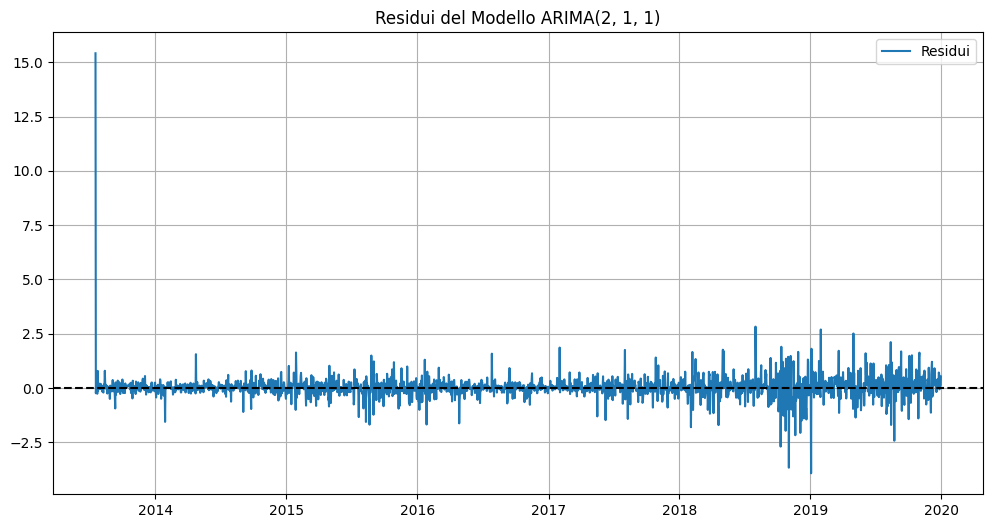

ARIMA(2, 1, 2): MAE = 60.05, RMSE = 66.84, MAPE = 41.03%


In [22]:
residuals = best_model.resid
plt.figure(figsize=(12, 6))
plt.plot(residuals, label="Residui")
plt.axhline(y=0, color='black', linestyle='--')
plt.title("Residui del Modello ARIMA(2, 1, 1)")
plt.legend()
plt.grid()
plt.show()

model_212 = ARIMA(train_data['close/last'], order=(2, 1, 2))
fitted_model_212 = model_212.fit()
forecast_212 = fitted_model_212.forecast(steps=len(test_data))

mae_212 = mean_absolute_error(test_data['close/last'], forecast_212)
rmse_212 = np.sqrt(mean_squared_error(test_data['close/last'], forecast_212))
mape_212 = np.mean(np.abs((test_data['close/last'] - forecast_212) / test_data['close/last'])) * 100

print(f"ARIMA(2, 1, 2): MAE = {mae_212:.2f}, RMSE = {rmse_212:.2f}, MAPE = {mape_212:.2f}%")



## RISULTATI CONFRONTO

Semplicità vs Accuratezza:

- ARIMA(2, 1, 1) è preferibile se si dà priorità alla semplicità e al miglior AIC.
- ARIMA(2, 1, 2) è più accurato in termini di previsioni, ma con un AIC leggermente peggiore.

**Se il focus è sull'accuratezza predittiva, ARIMA(2, 1, 2) sembra essere la scelta migliore.**

## DIVISIONE DATASET

In [23]:
print(df_cleaned['date'].head(10))  # Visualizza i primi 10 valori

# Verifica e correggi il formato della colonna 'date'
df_cleaned['date'] = pd.to_datetime(df_cleaned['date'], format='%d/%m/%Y', errors='coerce')

# Utilizzare il dataset pulito
df_apple = df_cleaned[df_cleaned['company'] == 'AAPL'][['date', 'close/last', 'volume']]
df_apple['date'] = pd.to_datetime(df_apple['date'], dayfirst=True)  # Usa il formato corretto
df_apple = df_apple.set_index('date')  # Imposta 'date' come indice
df_apple = df_apple.sort_index()  # Ordina l'indice

# Conferma la presenza di entrambe le colonne
print(df_apple.head())

# Verifica la suddivisione
print(f"Numero di osservazioni nel training set: {len(train_data)}")
print(f"Numero di osservazioni nel test set: {len(test_data)}")

0   2023-07-17
1   2023-07-14
2   2023-07-13
3   2023-07-12
4   2023-07-11
5   2023-07-10
6   2023-07-07
7   2023-07-06
8   2023-07-05
9   2023-07-03
Name: date, dtype: datetime64[ns]
            close/last     volume
date                             
2013-07-18     15.4199  218632537
2013-07-19     15.1768  268548901
2013-07-22     15.2254  207648981
2013-07-23     14.9639  354477618
2013-07-24     15.7325  591624923
Numero di osservazioni nel training set: 2358
Numero di osservazioni nel test set: 1295


## Applicazione modello ARIMA 

IN QUESTA SEZIONE (⬇️) HO CAPITO CHE ARIMA NON È IL TOP, PROVO CON SARIMA E CONFRONTO

Metriche ARIMA(2,1,2):
MAE: 62.47, RMSE: 69.27

Metriche SARIMA(2,1,2)x(1,0,1,12):
MAE: 62.40, RMSE: 69.20


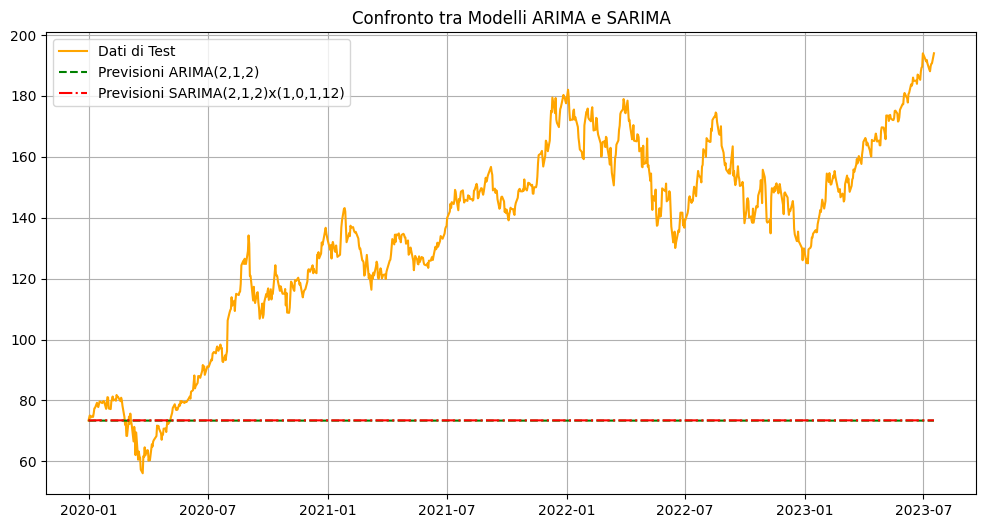

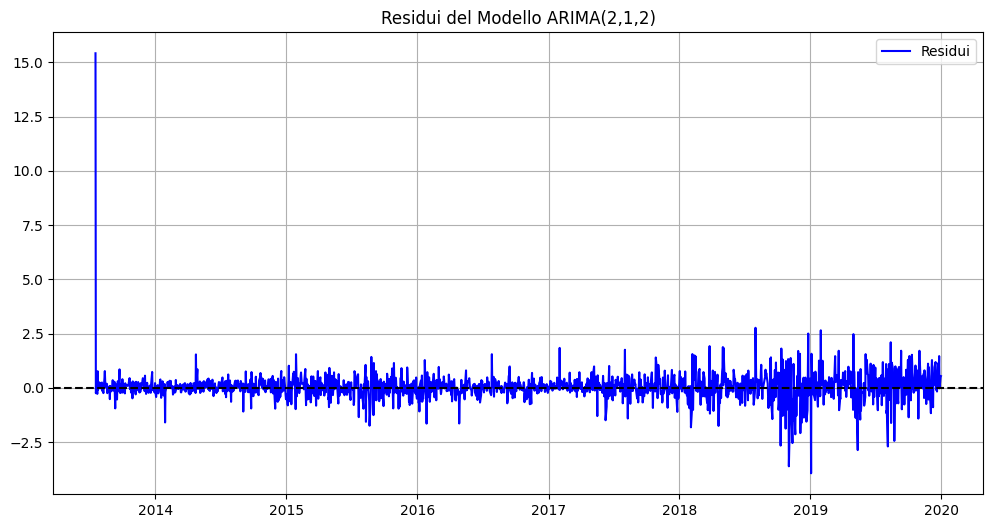

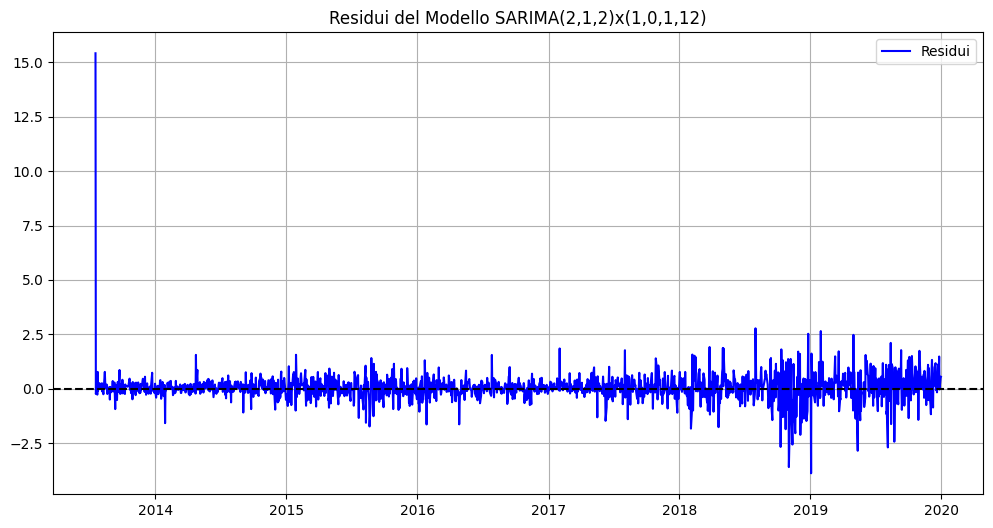

Confronto finale:
ARIMA - MAE: 62.47, RMSE: 69.27
SARIMA - MAE: 62.40, RMSE: 69.20


In [24]:
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1. Importazione e pulizia del dataset
df_cleaned['date'] = pd.to_datetime(df_cleaned['date'], format='%d/%m/%Y', errors='coerce')
df_apple = df_cleaned[df_cleaned['company'] == 'AAPL'][['date', 'close/last', 'volume']]
df_apple['date'] = pd.to_datetime(df_apple['date'], dayfirst=True)
df_apple = df_apple.set_index('date').sort_index()

# 2. Suddivisione in training e test
split_date = '2019-12-31'
train_data = df_apple[:split_date]
test_data = df_apple[split_date:]

# 3. Modello ARIMA(2,1,2)
arima_model = ARIMA(train_data['close/last'], order=(2, 1, 2))
arima_fit = arima_model.fit()
arima_forecast = arima_fit.forecast(steps=len(test_data))

# Calcolo metriche ARIMA
arima_mae = mean_absolute_error(test_data['close/last'], arima_forecast)
arima_rmse = np.sqrt(mean_squared_error(test_data['close/last'], arima_forecast))
print(f"Metriche ARIMA(2,1,2):")
print(f"MAE: {arima_mae:.2f}, RMSE: {arima_rmse:.2f}")

# 4. Modello SARIMA(2,1,2)x(1,0,1,12)
sarima_model = SARIMAX(train_data['close/last'], order=(2, 1, 2), seasonal_order=(1, 0, 1, 12))
sarima_fit = sarima_model.fit(disp=False)
sarima_forecast = sarima_fit.forecast(steps=len(test_data))

# Calcolo metriche SARIMA
sarima_mae = mean_absolute_error(test_data['close/last'], sarima_forecast)
sarima_rmse = np.sqrt(mean_squared_error(test_data['close/last'], sarima_forecast))
print(f"\nMetriche SARIMA(2,1,2)x(1,0,1,12):")
print(f"MAE: {sarima_mae:.2f}, RMSE: {sarima_rmse:.2f}")

# 5. Plot delle previsioni
plt.figure(figsize=(12, 6))
plt.plot(test_data['close/last'], label='Dati di Test', color='orange')
plt.plot(test_data.index, arima_forecast, label='Previsioni ARIMA(2,1,2)', linestyle='--', color='green')
plt.plot(test_data.index, sarima_forecast, label='Previsioni SARIMA(2,1,2)x(1,0,1,12)', linestyle='-.', color='red')
plt.title("Confronto tra Modelli ARIMA e SARIMA")
plt.legend()
plt.grid()
plt.show()

# 6. Residui ARIMA
residuals_arima = arima_fit.resid
plt.figure(figsize=(12, 6))
plt.plot(residuals_arima, label='Residui', color='blue')
plt.axhline(y=0, linestyle='--', color='black')
plt.title("Residui del Modello ARIMA(2,1,2)")
plt.legend()
plt.grid()
plt.show()

# 7. Residui SARIMA
residuals_sarima = sarima_fit.resid
plt.figure(figsize=(12, 6))
plt.plot(residuals_sarima, label='Residui', color='blue')
plt.axhline(y=0, linestyle='--', color='black')
plt.title("Residui del Modello SARIMA(2,1,2)x(1,0,1,12)")
plt.legend()
plt.grid()
plt.show()

# Conclusioni
print("Confronto finale:")
print(f"ARIMA - MAE: {arima_mae:.2f}, RMSE: {arima_rmse:.2f}")
print(f"SARIMA - MAE: {sarima_mae:.2f}, RMSE: {sarima_rmse:.2f}")


## I MODELLI DANNO PREVISIONI PIATTE: NON BUONO SECONDO ME

## FACCIO ALTRE PROVE ⬇️

**OTTIMIZZO I PARAMETRI DI ARIMA**

Miglior modello ARIMA: (4, 1, 3) con AIC: 2747.5102802719866
                               SARIMAX Results                                
Dep. Variable:             close/last   No. Observations:                 1625
Model:                 ARIMA(4, 1, 3)   Log Likelihood               -1365.755
Date:                Thu, 28 Nov 2024   AIC                           2747.510
Time:                        20:16:47   BIC                           2790.651
Sample:                             0   HQIC                          2763.518
                               - 1625                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.6690      0.037    -44.603      0.000      -1.742      -1.596
ar.L2         -0.9230      0.046    -20.028      0.000      -1.013    

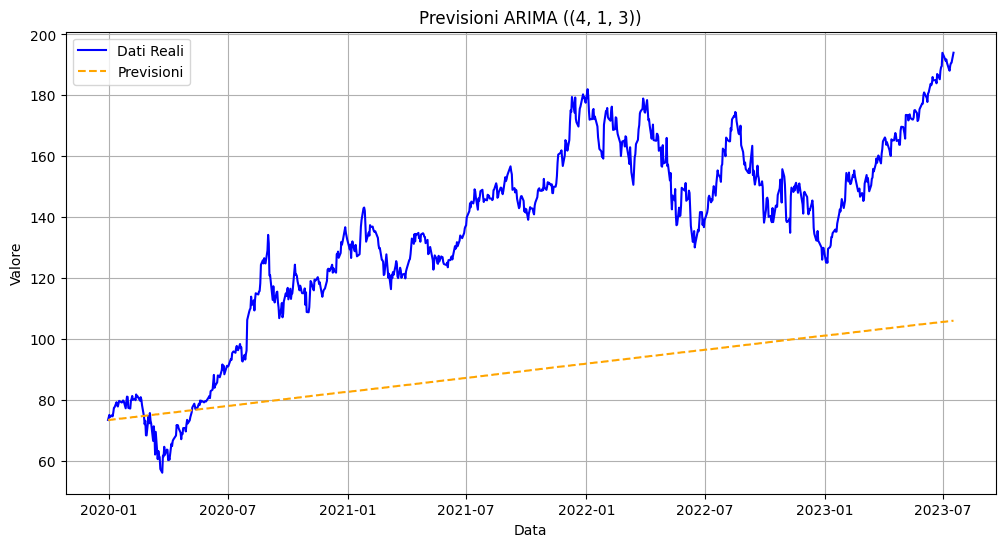

In [25]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Differenziazione dei dati (se necessario)
train_data_diff = train_data['close/last'].diff().dropna()

# Ottimizzazione del modello ARIMA
p = range(0, 5)
d = [1]  # Differenziazione manuale applicata
q = range(0, 5)
pdq = list(itertools.product(p, d, q))

best_model = None
best_aic = float('inf')
best_order = None

for param in pdq:
    try:
        model = ARIMA(train_data_diff, order=param)
        results = model.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_model = results
            best_order = param
    except:
        continue

print(f"Miglior modello ARIMA: {best_order} con AIC: {best_aic}")
print(best_model.summary())

# Previsioni con il miglior modello
forecast_diff = best_model.forecast(steps=len(test_data))

# Riallineamento dell'indice delle previsioni
forecast_diff.index = test_data.index

# Calcolo delle previsioni cumulative (se i dati sono differenziati)
forecast = train_data['close/last'].iloc[-1] + forecast_diff.cumsum()

# Metriche di accuratezza
mae = mean_absolute_error(test_data['close/last'], forecast)
rmse = np.sqrt(mean_squared_error(test_data['close/last'], forecast))
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

# Plot dei dati reali e delle previsioni
plt.figure(figsize=(12, 6))
plt.plot(test_data['close/last'], label="Dati Reali", color="blue")
plt.plot(forecast, label="Previsioni", linestyle="--", color="orange")
plt.title(f"Previsioni ARIMA ({best_order})")
plt.xlabel("Data")
plt.ylabel("Valore")
plt.legend()
plt.grid()
plt.show()


**METRICHE DI VALUTAZIONE ARIMA**

In [26]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import acf

# Assicurati che test_data sia un Series contenente la colonna 'close/last'
test_data_series = test_data['close/last']  # Seleziona la colonna corretta
test_data_series = pd.to_numeric(test_data_series, errors='coerce')  # Converte in numerico
test_data_series = test_data_series.dropna()  # Rimuove eventuali NaN
actual = np.array(test_data_series.values, dtype=float)  # Converte in array NumPy

# Ottieni forecast dal modello
forecast = np.array(results.get_forecast(steps=len(test_data_series)).predicted_mean.values, dtype=float)

# Calcolo delle metriche
me = np.mean(forecast - actual)  # Mean Error (ME)
mae = np.mean(np.abs(forecast - actual))  # Mean Absolute Error (MAE)
mpe = np.mean((forecast - actual) / actual) * 100  # Mean Percentage Error (MPE)
mape = np.mean(np.abs((forecast - actual) / actual)) * 100  # Mean Absolute Percentage Error (MAPE)
rmse = np.sqrt(np.mean((forecast - actual) ** 2))  # Root Mean Squared Error (RMSE)

# Calcolo di ACF1
error = forecast - actual  # Calcola l'errore
acf1 = acf(error, nlags=1, fft=False)[1]  # Lag 1 Autocorrelation of Error (ACF1)

# Correlazione tra valori reali e previsione
corr = np.corrcoef(actual, forecast)[0, 1]  # Correlation between Actual and Forecast

# Min-Max Error
minmax = np.mean(np.abs(forecast - actual) / (np.max(actual) - np.min(actual)))  # Min-Max Error

# Creazione di una tabella con i risultati
metrics = {
    "Metric": ["ME", "MAE", "MPE", "MAPE", "RMSE", "ACF1", "Corr", "Min-Max Error"],
    "Value": [me, mae, mpe, mape, rmse, acf1, corr, minmax]
}

metrics_df = pd.DataFrame(metrics)

# Stampa della tabella
print("Metriche di valutazione del modello ARIMA:")
print(metrics_df.to_string(index=False))


Metriche di valutazione del modello ARIMA:
       Metric       Value
           ME -135.070833
          MAE  135.070833
          MPE  -99.910244
         MAPE   99.910244
         RMSE  138.648117
         ACF1    0.992114
         Corr    0.000966
Min-Max Error    0.979502


❌ METRICHE NON OTTIMALI

**GRAFICI DIAGNOSTICI ARIMA**

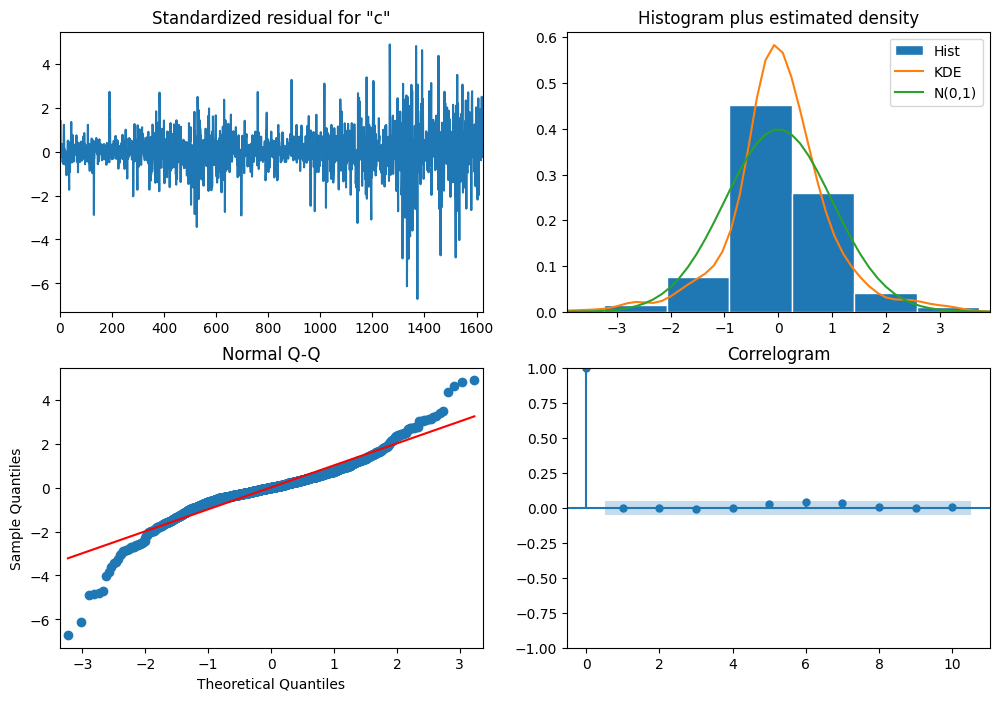

In [27]:
import matplotlib.pyplot as plt

# Grafici diagnostici per il modello ARIMA
results.plot_diagnostics(figsize=(12, 8))
plt.show()

## OTTIMIZZAZIONE E APPLICAZIONE SARIMA

Migliori parametri SARIMA: (0, 1, 0, 2, 1, 2, 12), AIC: 2796.14
                                        SARIMAX Results                                        
Dep. Variable:                              close/last   No. Observations:                 1626
Model:             SARIMAX(0, 1, 0)x(2, 1, [1, 2], 12)   Log Likelihood               -1393.072
Date:                                 Thu, 28 Nov 2024   AIC                           2796.145
Time:                                         20:21:28   BIC                           2823.074
Sample:                                              0   HQIC                          2806.141
                                                - 1626                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12  

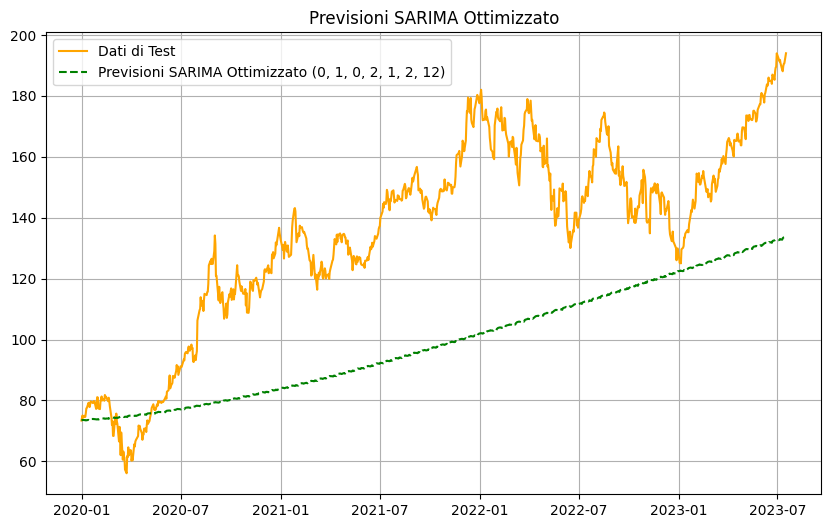

In [28]:
import itertools
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Definizione dei range di parametri
p = range(0, 3)   # Ordine AR
d = [1]           # Differenziazione
q = range(0, 3)   # Ordine MA
P = range(0, 3)   # Ordine stagionale AR
D = [1]           # Differenziazione stagionale
Q = range(0, 3)   # Ordine stagionale MA
s = [12]          # Periodo stagionale (mensile)

# Genera tutte le combinazioni possibili di parametri
param_combinations = list(itertools.product(p, d, q, P, D, Q, s))

# Variabili per memorizzare i risultati
best_aic = float('inf')
best_params = None
best_model = None
results_summary = []

# Ciclo su tutte le combinazioni di parametri
for param in param_combinations:
    try:
        # Adatta il modello SARIMA
        model = SARIMAX(
            train_data['close/last'],
            order=(param[0], param[1], param[2]),
            seasonal_order=(param[3], param[4], param[5], param[6])
        )
        results = model.fit(disp=False)
        
        # Confronta l'AIC
        if results.aic < best_aic:
            best_aic = results.aic
            best_params = param
            best_model = results
        
        # Salva i risultati
        results_summary.append({
            'Params': param,
            'AIC': results.aic
        })
    except Exception as e:
        continue

# Ordina i risultati per AIC
results_summary = sorted(results_summary, key=lambda x: x['AIC'])

# Stampa i migliori parametri
print(f"Migliori parametri SARIMA: {best_params}, AIC: {best_aic:.2f}")

# Dettagli del miglior modello
if best_model:
    print(best_model.summary())

# Previsioni con il modello ottimizzato
forecast = best_model.forecast(steps=len(test_data))

# Riallinea l'indice delle previsioni con i dati di test
forecast.index = test_data.index

# Calcolo delle metriche di accuratezza
mae = mean_absolute_error(test_data['close/last'], forecast)
rmse = np.sqrt(mean_squared_error(test_data['close/last'], forecast))

print(f"MAE del modello ottimizzato: {mae:.2f}")
print(f"RMSE del modello ottimizzato: {rmse:.2f}")

# Grafico delle previsioni
plt.figure(figsize=(10, 6))
plt.plot(test_data['close/last'], label="Dati di Test", color="orange")
plt.plot(forecast, label=f"Previsioni SARIMA Ottimizzato {best_params}", linestyle="--", color="green")
plt.title("Previsioni SARIMA Ottimizzato")
plt.legend()
plt.grid()
plt.show()


✅ **Il modello SARIMA ottimizzato sta performando meglio rispetto al modello ARIMA**

## OTTIMIZZAZIONE E APPLICAZIONE SARIMAX

**Le previsioni dovrebbero ora essere più accurate, includendo variabili esogene come il volume.**

Migliori parametri SARIMAX: (0, 1, 0, 0, 1, 2, 12), AIC: 2873.84
                                        SARIMAX Results                                        
Dep. Variable:                              close/last   No. Observations:                 1626
Model:             SARIMAX(0, 1, 0)x(0, 1, [1, 2], 12)   Log Likelihood               -1432.920
Date:                                 Thu, 28 Nov 2024   AIC                           2873.840
Time:                                         20:24:41   BIC                           2895.384
Sample:                                              0   HQIC                          2881.837
                                                - 1626                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
volume   

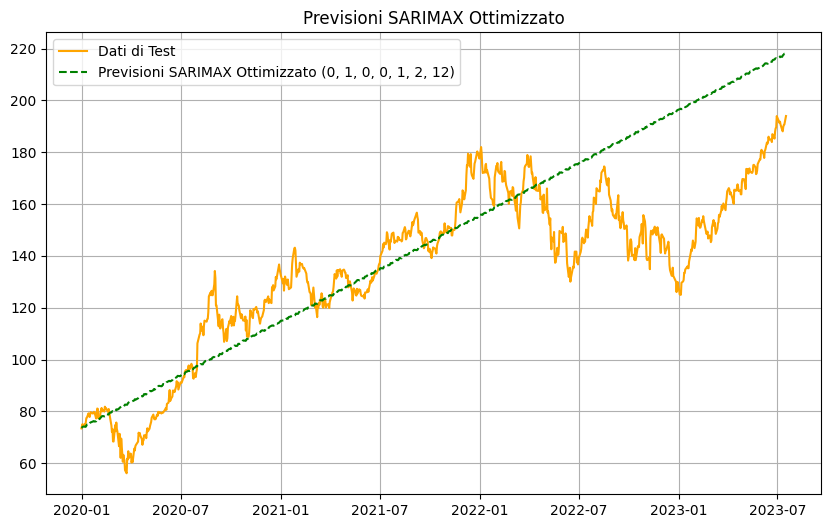

In [29]:
import itertools
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Definizione dei range di parametri
p = range(0, 3)   # Ordine AR
d = [1]           # Differenziazione
q = range(0, 3)   # Ordine MA
P = range(0, 3)   # Ordine stagionale AR
D = [1]           # Differenziazione stagionale
Q = range(0, 3)   # Ordine stagionale MA
s = [12]          # Periodo stagionale (mensile)

# Genera tutte le combinazioni possibili di parametri
param_combinations = list(itertools.product(p, d, q, P, D, Q, s))

# Variabili per memorizzare i risultati
best_aic = float('inf')
best_params = None
best_model = None
results_summary = []

# Ciclo su tutte le combinazioni di parametri
for param in param_combinations:
    try:
        # Adatta il modello SARIMAX con il volume come variabile esogena
        model = SARIMAX(
            train_data['close/last'],
            exog=train_data['volume'],  # Variabile esogena
            order=(param[0], param[1], param[2]),
            seasonal_order=(param[3], param[4], param[5], param[6])
        )
        results = model.fit(disp=False)
        
        # Confronta l'AIC
        if results.aic < best_aic:
            best_aic = results.aic
            best_params = param
            best_model = results
        
        # Salva i risultati
        results_summary.append({
            'Params': param,
            'AIC': results.aic
        })
    except Exception as e:
        continue

# Ordina i risultati per AIC
results_summary = sorted(results_summary, key=lambda x: x['AIC'])

# Stampa i migliori parametri
print(f"Migliori parametri SARIMAX: {best_params}, AIC: {best_aic:.2f}")

# Dettagli del miglior modello
if best_model:
    print(best_model.summary())

# Previsioni con il modello ottimizzato
forecast = best_model.forecast(steps=len(test_data), exog=test_data['volume'])

# Riallinea l'indice delle previsioni con i dati di test
forecast.index = test_data.index

# Calcolo delle metriche di accuratezza
mae = mean_absolute_error(test_data['close/last'], forecast)
rmse = np.sqrt(mean_squared_error(test_data['close/last'], forecast))

print(f"MAE del modello ottimizzato: {mae:.2f}")
print(f"RMSE del modello ottimizzato: {rmse:.2f}")

# Grafico delle previsioni
plt.figure(figsize=(10, 6))
plt.plot(test_data['close/last'], label="Dati di Test", color="orange")
plt.plot(forecast, label=f"Previsioni SARIMAX Ottimizzato {best_params}", linestyle="--", color="green")
plt.title("Previsioni SARIMAX Ottimizzato")
plt.legend()
plt.grid()
plt.show()


✅ **Il modello SARIMAX performa meglio rispetto ad ARIMA e SARIMA**

## DI NUOVO SARIMAX

Migliori parametri SARIMAX: (0, 1, 0, 0, 1, 2, 12), AIC: 2873.84
                                        SARIMAX Results                                        
Dep. Variable:                              close/last   No. Observations:                 1626
Model:             SARIMAX(0, 1, 0)x(0, 1, [1, 2], 12)   Log Likelihood               -1432.920
Date:                                 Thu, 28 Nov 2024   AIC                           2873.840
Time:                                         20:33:25   BIC                           2895.384
Sample:                                              0   HQIC                          2881.837
                                                - 1626                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
volume   

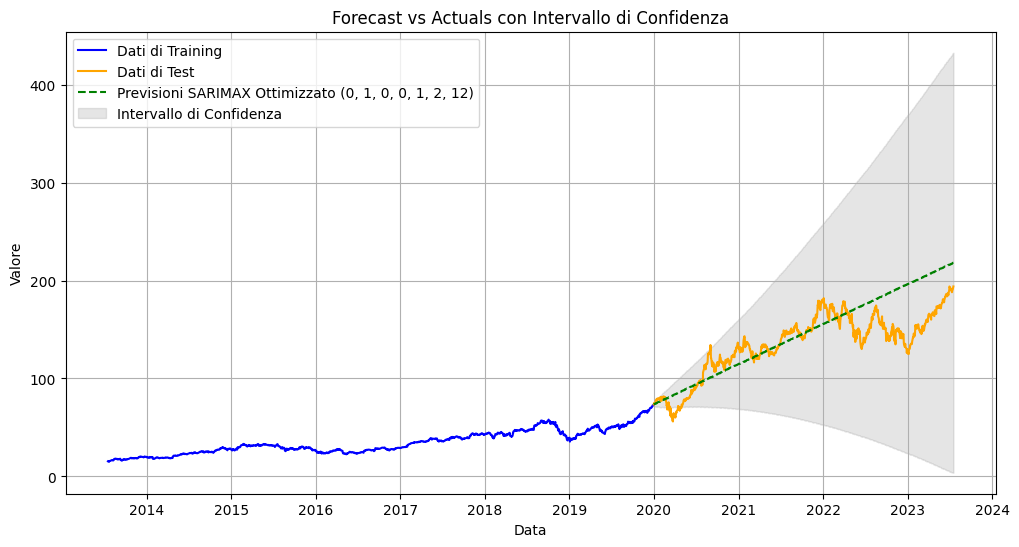

In [30]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Definizione dei range di parametri
p = range(0, 6)   # Ordine AR
d = [1]           # Differenziazione
q = range(0, 3)   # Ordine MA
P = range(0, 3)   # Ordine stagionale AR
D = [1]           # Differenziazione stagionale
Q = range(0, 3)   # Ordine stagionale MA
s = [12]          # Periodo stagionale (mensile)

# Genera tutte le combinazioni possibili di parametri
param_combinations = list(itertools.product(p, d, q, P, D, Q, s))

# Variabili per memorizzare i risultati
best_aic = float('inf')
best_params = None
best_model = None
results_summary = []

# Ciclo su tutte le combinazioni di parametri
for param in param_combinations:
    try:
        # Adatta il modello SARIMAX con il volume come variabile esogena
        model = SARIMAX(
            train_data['close/last'],
            exog=train_data['volume'],  # Variabile esogena
            order=(param[0], param[1], param[2]),
            seasonal_order=(param[3], param[4], param[5], param[6])
        )
        results = model.fit(disp=False)
        
        # Confronta l'AIC
        if results.aic < best_aic:
            best_aic = results.aic
            best_params = param
            best_model = results
        
        # Salva i risultati
        results_summary.append({
            'Params': param,
            'AIC': results.aic
        })
    except Exception as e:
        continue

# Ordina i risultati per AIC
results_summary = sorted(results_summary, key=lambda x: x['AIC'])

# Stampa i migliori parametri
print(f"Migliori parametri SARIMAX: {best_params}, AIC: {best_aic:.2f}")

# Dettagli del miglior modello
if best_model:
    print(best_model.summary())

# Previsioni con il modello ottimizzato
forecast = best_model.get_forecast(steps=len(test_data), exog=test_data['volume'])

# Riallinea l'indice delle previsioni con i dati di test
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

forecast_mean.index = test_data.index
forecast_conf_int.index = test_data.index

# Calcolo delle metriche di accuratezza
mae = mean_absolute_error(test_data['close/last'], forecast_mean)
rmse = np.sqrt(mean_squared_error(test_data['close/last'], forecast_mean))

print(f"MAE del modello ottimizzato: {mae:.2f}")
print(f"RMSE del modello ottimizzato: {rmse:.2f}")

# Grafico delle previsioni con area di incertezza
plt.figure(figsize=(12, 6))
plt.plot(train_data['close/last'], label="Dati di Training", color="blue")
plt.plot(test_data['close/last'], label="Dati di Test", color="orange")
plt.plot(forecast_mean, label=f"Previsioni SARIMAX Ottimizzato {best_params}", linestyle="--", color="green")

# Aggiungi l'area di incertezza (intervallo di confidenza)
plt.fill_between(forecast_conf_int.index,
                 forecast_conf_int.iloc[:, 0], 
                 forecast_conf_int.iloc[:, 1], 
                 color='gray', alpha=0.2, label="Intervallo di Confidenza")

plt.title("Forecast vs Actuals con Intervallo di Confidenza")
plt.xlabel("Data")
plt.ylabel("Valore")
plt.legend()
plt.grid(True)
plt.show()


## Forecast ARIMA

Modello ARIMA ((4, 1, 3))
                               SARIMAX Results                                
Dep. Variable:             close/last   No. Observations:                 1625
Model:                 ARIMA(4, 1, 3)   Log Likelihood               -1365.755
Date:                Thu, 28 Nov 2024   AIC                           2747.510
Time:                        21:27:26   BIC                           2790.651
Sample:                             0   HQIC                          2763.518
                               - 1625                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.6690      0.037    -44.603      0.000      -1.742      -1.596
ar.L2         -0.9230      0.046    -20.028      0.000      -1.013      -0.833
ar.L3         -0.1126     

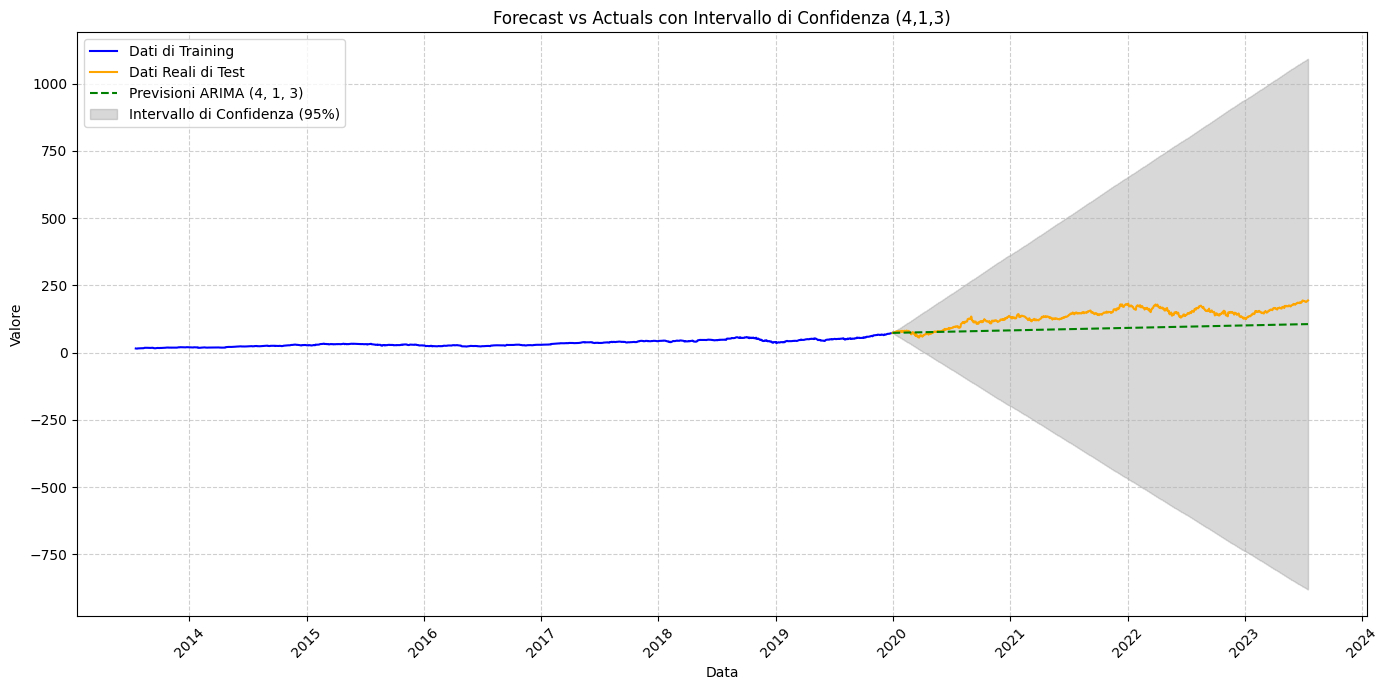

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Differenziazione dei dati per ARIMA (se necessaria)
train_data_diff = train_data['close/last'].diff().dropna()

# Imposta i parametri ARIMA fissi (4, 1, 3)
order = (4, 1, 3)
model = ARIMA(train_data_diff, order=order)
results = model.fit()

print(f"Modello ARIMA ({order})")
print(results.summary())

# Previsioni con il modello
forecast_diff = results.get_forecast(steps=len(test_data))
forecast_diff_mean = forecast_diff.predicted_mean
forecast_diff_conf_int = forecast_diff.conf_int()

# Riallineamento dell'indice delle previsioni
forecast_diff_mean.index = test_data.index
forecast_diff_conf_int.index = test_data.index

# Calcolo delle previsioni cumulative per riportarle al livello originale
forecast = train_data['close/last'].iloc[-1] + forecast_diff_mean.cumsum()

# Calcolo delle metriche di accuratezza
mae = mean_absolute_error(test_data['close/last'], forecast)
rmse = np.sqrt(mean_squared_error(test_data['close/last'], forecast))
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

# Plot migliorato dei dati reali e delle previsioni
plt.figure(figsize=(14, 7))
plt.plot(train_data['close/last'], label="Dati di Training", color="blue")
plt.plot(test_data['close/last'], label="Dati Reali di Test", color="orange")
plt.plot(forecast, label=f"Previsioni ARIMA {order}", linestyle="--", color="green")

# Area dell'intervallo di confidenza
plt.fill_between(
    forecast_diff_conf_int.index,
    train_data['close/last'].iloc[-1] + forecast_diff_conf_int.iloc[:, 0].cumsum(),
    train_data['close/last'].iloc[-1] + forecast_diff_conf_int.iloc[:, 1].cumsum(),
    color='gray', alpha=0.3, label="Intervallo di Confidenza (95%)"
)

plt.title(f"Forecast vs Actuals con Intervallo di Confidenza (4,1,3)")
plt.xlabel("Data")
plt.ylabel("Valore")
plt.xticks(rotation=45)
plt.legend(loc="upper left")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()  
plt.show()


## Forecast SARIMA

Migliori parametri SARIMA: (0, 1, 0, 2, 1, 2, 12), AIC: 2796.14
                                        SARIMAX Results                                        
Dep. Variable:                              close/last   No. Observations:                 1626
Model:             SARIMAX(0, 1, 0)x(2, 1, [1, 2], 12)   Log Likelihood               -1393.072
Date:                                 Thu, 28 Nov 2024   AIC                           2796.145
Time:                                         21:32:21   BIC                           2823.074
Sample:                                              0   HQIC                          2806.141
                                                - 1626                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12  

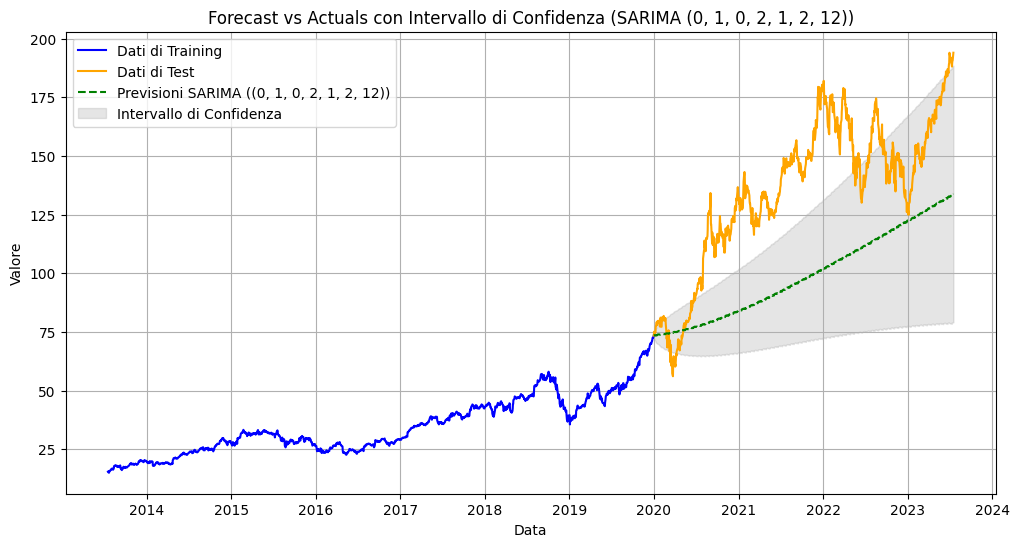

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Impostazione dei parametri SARIMA fissi
order = (0, 1, 0)  # Ordine AR, differenziazione, ordine MA
seasonal_order = (2, 1, 2, 12)  # Ordine stagionale AR, differenziazione stagionale, ordine stagionale MA, periodo stagionale (12 mesi)

# Adatta il modello SARIMA con i parametri fissi
model = SARIMAX(
    train_data['close/last'],
    order=order,
    seasonal_order=seasonal_order
)
results = model.fit(disp=False)

# Stampa del sommario del modello
print(f"Migliori parametri SARIMA: {order + seasonal_order}, AIC: {results.aic:.2f}")
print(results.summary())

# Previsioni con il modello SARIMA ottimizzato
forecast = results.get_forecast(steps=len(test_data))

# Riallinea l'indice delle previsioni con i dati di test
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

forecast_mean.index = test_data.index
forecast_conf_int.index = test_data.index

# Calcolo delle metriche di accuratezza
mae = mean_absolute_error(test_data['close/last'], forecast_mean)
rmse = np.sqrt(mean_squared_error(test_data['close/last'], forecast_mean))

print(f"MAE del modello SARIMA ottimizzato: {mae:.2f}")
print(f"RMSE del modello SARIMA ottimizzato: {rmse:.2f}")

# Grafico delle previsioni con area di incertezza
plt.figure(figsize=(12, 6))
plt.plot(train_data['close/last'], label="Dati di Training", color="blue")
plt.plot(test_data['close/last'], label="Dati di Test", color="orange")
plt.plot(forecast_mean, label=f"Previsioni SARIMA ({order + seasonal_order})", linestyle="--", color="green")

# Area di incertezza (intervallo di confidenza)
plt.fill_between(forecast_conf_int.index,
                 forecast_conf_int.iloc[:, 0], 
                 forecast_conf_int.iloc[:, 1], 
                 color='gray', alpha=0.2, label="Intervallo di Confidenza")

plt.title(f"Forecast vs Actuals con Intervallo di Confidenza (SARIMA {order + seasonal_order})")
plt.xlabel("Data")
plt.ylabel("Valore")
plt.legend()
plt.grid(True)
plt.show()


**CALCOLO LE METRICHE DI SARIMAX**

In [77]:
# Prepara i dati esogeni per il test set (ad esempio, 'volume' è la variabile esogena)
exog_test = test_data[['volume']]  # Assicurati che i dati esogeni siano nel test set

# Ottieni forecast dal modello SARIMAX ottimizzato, passando 'exog_test' come esogeno
forecast = np.array(best_model.get_forecast(steps=len(test_data_series), exog=exog_test).predicted_mean.values, dtype=float)

# Calcolo delle metriche
me = np.mean(forecast - actual)  # Mean Error (ME)
mae = np.mean(np.abs(forecast - actual))  # Mean Absolute Error (MAE)
mpe = np.mean((forecast - actual) / actual) * 100  # Mean Percentage Error (MPE)
mape = np.mean(np.abs((forecast - actual) / actual)) * 100  # Mean Absolute Percentage Error (MAPE)
rmse = np.sqrt(np.mean((forecast - actual) ** 2))  # Root Mean Squared Error (RMSE)

# Calcolo di ACF1 (Autocorrelazione dei residui al lag 1)
error = forecast - actual  # Calcola l'errore
acf1 = acf(error, nlags=1, fft=False)[1]  # Lag 1 Autocorrelation of Error (ACF1)

# Correlazione tra valori reali e previsione
corr = np.corrcoef(actual, forecast)[0, 1]  # Correlation between Actual and Forecast

# Min-Max Error
minmax = np.mean(np.abs(forecast - actual) / (np.max(actual) - np.min(actual)))  # Min-Max Error

# Creazione di una tabella con i risultati
metrics = {
    "Metric": ["ME", "MAE", "MPE", "MAPE", "RMSE", "ACF1", "Corr", "Min-Max Error"],
    "Value": [me, mae, mpe, mape, rmse, acf1, corr, minmax]
}

metrics_df = pd.DataFrame(metrics)

# Stampa della tabella
print("Metriche di valutazione del modello SARIMAX:")
print(metrics_df.to_string(index=False))


Metriche di valutazione del modello SARIMAX:
       Metric     Value
           ME 10.630630
          MAE 18.911452
          MPE  7.818074
         MAPE 13.863910
         RMSE 25.516466
         ACF1  0.992933
         Corr  0.835357
Min-Max Error  0.137141


## CONFRONTO METRICHE ARIMA E SARIMAX

In [78]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.stattools import acf
import itertools
import matplotlib.pyplot as plt

# Funzione per calcolare le metriche
def calculate_metrics(forecast, actual):
    # Calcolo delle metriche
    me = np.mean(forecast - actual)  # Mean Error (ME)
    mae = np.mean(np.abs(forecast - actual))  # Mean Absolute Error (MAE)
    mpe = np.mean((forecast - actual) / actual) * 100  # Mean Percentage Error (MPE)
    mape = np.mean(np.abs((forecast - actual) / actual)) * 100  # Mean Absolute Percentage Error (MAPE)
    rmse = np.sqrt(np.mean((forecast - actual) ** 2))  # Root Mean Squared Error (RMSE)

    # Calcolo di ACF1 (Autocorrelazione dei residui al lag 1)
    error = forecast - actual  # Calcola l'errore
    acf1 = acf(error, nlags=1, fft=False)[1]  # Lag 1 Autocorrelation of Error (ACF1)

    # Correlazione tra valori reali e previsione
    corr = np.corrcoef(actual, forecast)[0, 1]  # Correlation between Actual and Forecast

    # Min-Max Error
    minmax = np.mean(np.abs(forecast - actual) / (np.max(actual) - np.min(actual)))  # Min-Max Error

    return [me, mae, mpe, mape, rmse, acf1, corr, minmax]

# Prepara i dati esogeni per il test set (ad esempio, 'volume' è la variabile esogena)
exog_test = test_data[['volume']]  # Assicurati che i dati esogeni siano nel test set
test_data_series = test_data['close/last']
test_data_series = pd.to_numeric(test_data_series, errors='coerce').dropna()  # Converte in numerico
actual = np.array(test_data_series.values, dtype=float)  # Converte in array NumPy

# =============================
# 1. ARIMA MODEL

# Differenziazione dei dati (se necessario)
train_data_diff = train_data['close/last'].diff().dropna()

# Ottimizzazione del modello ARIMA
p = range(0, 5)
d = [1]  # Differenziazione manuale applicata
q = range(0, 5)
pdq = list(itertools.product(p, d, q))

best_arima_model = None
best_aic_arima = float('inf')
best_order_arima = None

for param in pdq:
    try:
        model = ARIMA(train_data_diff, order=param)
        results = model.fit()
        if results.aic < best_aic_arima:
            best_aic_arima = results.aic
            best_arima_model = results
            best_order_arima = param
    except:
        continue

print(f"Miglior modello ARIMA: {best_order_arima} con AIC: {best_aic_arima}")
print(best_arima_model.summary())

# Previsioni con il miglior modello ARIMA
forecast_arima = best_arima_model.forecast(steps=len(test_data))

# Calcolo delle metriche di ARIMA
arima_metrics = calculate_metrics(forecast_arima, actual)

# =============================
# 2. SARIMAX MODEL

# Definizione dei range di parametri per SARIMAX
p = range(0, 3)   # Ordine AR
d = [1]           # Differenziazione
q = range(0, 3)   # Ordine MA
P = range(0, 3)   # Ordine stagionale AR
D = [1]           # Differenziazione stagionale
Q = range(0, 3)   # Ordine stagionale MA
s = [12]          # Periodo stagionale (mensile)

# Genera tutte le combinazioni possibili di parametri
param_combinations = list(itertools.product(p, d, q, P, D, Q, s))

best_sarimax_model = None
best_aic_sarimax = float('inf')
best_params_sarimax = None
results_summary_sarimax = []

for param in param_combinations:
    try:
        # Adatta il modello SARIMAX con il volume come variabile esogena
        model = SARIMAX(
            train_data['close/last'],
            exog=train_data['volume'],  # Variabile esogena
            order=(param[0], param[1], param[2]),
            seasonal_order=(param[3], param[4], param[5], param[6])
        )
        results = model.fit(disp=False)
        
        # Confronta l'AIC
        if results.aic < best_aic_sarimax:
            best_aic_sarimax = results.aic
            best_params_sarimax = param
            best_sarimax_model = results
        
        # Salva i risultati
        results_summary_sarimax.append({
            'Params': param,
            'AIC': results.aic
        })
    except Exception as e:
        continue

# Stampa i migliori parametri
print(f"Migliori parametri SARIMAX: {best_params_sarimax}, AIC: {best_aic_sarimax:.2f}")

# Dettagli del miglior modello
if best_sarimax_model:
    print(best_sarimax_model.summary())

# Previsioni con il modello ottimizzato
forecast_sarimax = best_sarimax_model.forecast(steps=len(test_data), exog=exog_test)

# Calcolo delle metriche di SARIMAX
sarimax_metrics = calculate_metrics(forecast_sarimax, actual)

# =============================
# Creazione della tabella di confronto
comparison_df = pd.DataFrame({
    "Metric": ["ME", "MAE", "MPE", "MAPE", "RMSE", "ACF1", "Corr", "Min-Max Error"],
    "ARIMA": arima_metrics,
    "SARIMAX": sarimax_metrics
})

# Visualizzare la tabella
from IPython.display import display
display(comparison_df)

# Stampa la tabella di confronto
print(comparison_df)


Miglior modello ARIMA: (4, 1, 3) con AIC: 2747.5102802719866
                               SARIMAX Results                                
Dep. Variable:             close/last   No. Observations:                 1625
Model:                 ARIMA(4, 1, 3)   Log Likelihood               -1365.755
Date:                Thu, 28 Nov 2024   AIC                           2747.510
Time:                        18:38:29   BIC                           2790.651
Sample:                             0   HQIC                          2763.518
                               - 1625                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.6690      0.037    -44.603      0.000      -1.742      -1.596
ar.L2         -0.9230      0.046    -20.028      0.000      -1.013    

,Metric,ARIMA,SARIMAX
0,ME,-135.147170,10.630630
1,MAE,135.147170,18.911452
2,MPE,-99.970985,7.818074
3,MAPE,99.970985,13.863910
4,RMSE,138.722455,25.516466
5,ACF1,0.992119,0.992933
6,Corr,0.017689,0.835357
7,Min-Max Error,0.980055,0.137141


          Metric       ARIMA    SARIMAX
0             ME -135.147170  10.630630
1            MAE  135.147170  18.911452
2            MPE  -99.970985   7.818074
3           MAPE   99.970985  13.863910
4           RMSE  138.722455  25.516466
5           ACF1    0.992119   0.992933
6           Corr    0.017689   0.835357
7  Min-Max Error    0.980055   0.137141


✅ SARIMAX appare superioriore rispetto ad ARIMA, con previsioni più precise e una migliore capacità di catturare la dinamica dei dati.